In [ ]:
# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from warnings import filterwarnings 

filterwarnings('ignore')

# i/o directories
INPUT_DIR = './data'
OUTPUT_DIR = './'
FIGURES_DIR = os.path.join(OUTPUT_DIR, 'figures')
RESULTS_DIR = os.path.join(OUTPUT_DIR, 'results')

# create directories if they do not exist
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
# set seed for reproducibility
np.random.seed(420)
torch.manual_seed(420)
random.seed(420)

# set device
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

[]

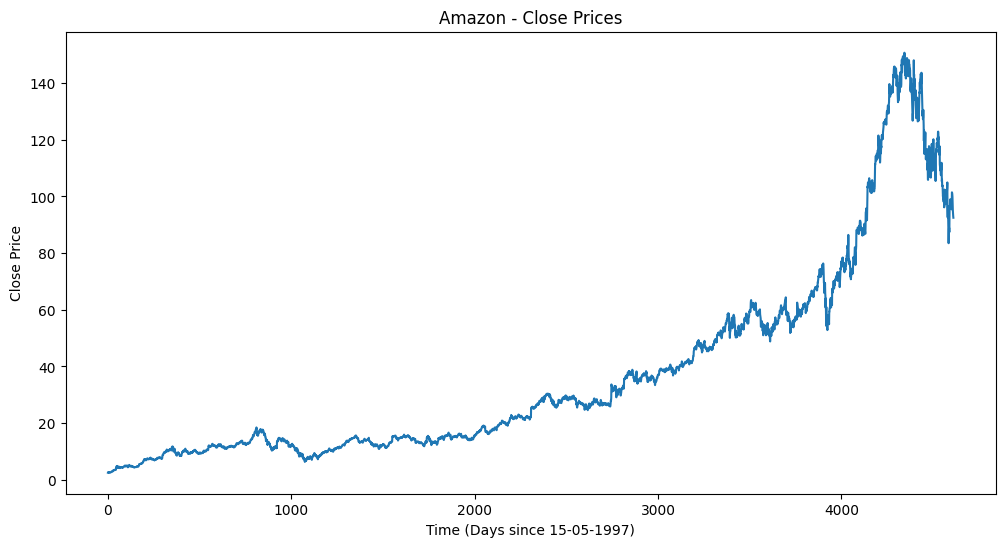

In [ ]:
# set stock and read data (data is avaialble only for Google based on project requirements)
stock = 'GOOG'
stock_path = os.path.join(INPUT_DIR, f"{stock}.csv")
stock_data = pd.read_csv(stock_path)

# plot the close prices
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='Close Price')
# initially I was working on Amazon data and then I saw that I have to work on Google's data.
# I didn't see that I was using Amazon in the title until I was about to submit the project.
# Therefore, I've just changed it over here but it wouldn't be reflected in the plot since I haven't run the cell again.
plt.title("Google - Close Prices")
plt.xlabel("Time (Days since 15-05-1997)")
plt.ylabel("Close Price")
plt.plot()

In [ ]:
class StockDataset(Dataset):
    def __init__(self, data, seq_length):
        '''
        function: initialise the stock dataset
        params:
            data: stock data
            seq_length: sequence length
        return: None
        '''
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        '''
        function: get the length of the dataset
        params: None
        return: length of the dataset
        '''
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        '''
        function: get the item at the given index
        params:
            idx: index
        return: features, target, previous target
        '''
        x = self.data[idx:idx + self.seq_length, :-1] # features for the sequence (price change is the last column, excluded)
        y = self.data[idx + self.seq_length, -1] # get the target column which is price change
        if idx == 0:  # for the first sample, use the current target as the previous day's target
            prev_y = y
        else:
            prev_y = self.data[idx + self.seq_length - 1, -1]  # previous day's target
        return (
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32),
            torch.tensor(prev_y, dtype=torch.float32)
        ) # we are returning previous targets since they are used in the loss function

In [ ]:
def minmax_scale(data):
    '''
    function: performs min-max scaling
    params:
        data: input data
    return: scaled data, min and max values for each column
    '''
    # calculate min and max for each column
    min_val = data.min(axis=0)
    max_val = data.max(axis=0)
    
    # perform min-max scaling
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data, min_val, max_val # return scaled data and min-max values for each column

def minmax_inverse_scale(scaled_data, min_val, max_val):
    '''
    function: performs inverse min-max scaling
    params:
        scaled_data: scaled data
        min_val: min values for each column
        max_val: max values for each column
    return: inverse scaled data
    '''
    return (scaled_data * (max_val - min_val)) + min_val # return inverse scaled data

In [ ]:
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_days=1, num_layers=1, dropout=0.25):
        '''
        function: initialise the custom RNN model
        params:
            input_size: input size
            hidden_size: hidden size
            output_size: output size
            num_days: number of days
            num_layers: number of layers
            dropout: dropout rate
        return: None
        '''
        super(CustomRNN, self).__init__()
        self.num_days = num_days
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout) # rnn
        self.fc = nn.Linear(hidden_size, num_days * output_size) # fc layer

    def forward(self, x):
        '''
        function: forward pass
        params:
            x: input data
        return: output
        '''
        out, _ = self.rnn(x) # rnn output
        out = self.fc(out[:, -1, :])  # fc layer and then output from the last time step
        return out.view(-1, self.num_days)

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_days=1, num_layers=1, dropout=0.25):
        '''
        function: initialise the custom LSTM model
        params:
            input_size: input size
            hidden_size: hidden size
            output_size: output size
            num_days: number of days
            num_layers: number of layers
            dropout: dropout rate
        return: None
        '''
        super(CustomLSTM, self).__init__()
        self.num_days = num_days
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout) # lstm
        self.fc = nn.Linear(hidden_size, num_days * output_size) # fc layer

    def forward(self, x):
        '''
        function: forward pass
        params:
            x: input data
        return: output
        '''
        out, _ = self.lstm(x) # lstm output
        out = self.fc(out[:, -1, :])  # fc layer and then output from the last time step
        return out.view(-1, self.num_days)

In [ ]:
def hybrid_loss(outputs, targets, previous_targets, criterion, alpha=0.5):
    '''
    function: hybrid loss function
    params:
        outputs: model outputs
        targets: target values
        previous_targets: previous target values
        criterion: loss function
        alpha: alpha value
    return: total loss
    '''
    outputs = outputs.squeeze() # squeeze outputs to remove extra dimension
    loss = criterion(outputs, targets) # MSE loss between outputs and targets
    penalty = alpha * criterion(outputs, previous_targets) # MSE loss between outputs and previous targets (multiplied by alpha)
    total_loss = loss - penalty # total loss
    return total_loss

def train_model(model, train_loader, criterion, optimizer, device, alpha=0.5):
    '''
    function: train the model
    params:
        model: model
        train_loader: train data loader
        criterion: loss function
        optimizer: optimizer
        device: device
        alpha: alpha value
    return: average loss
    ''' 
    model.train() # set model to training mode
    total_loss = 0.0 # initialise total loss
    for batch in train_loader: # iterate over the training data
        inputs, targets, previous_targets = batch # get inputs, targets and previous targets
        inputs, targets, previous_targets = inputs.to(device), targets.to(device), previous_targets.to(device) # move to device

        optimizer.zero_grad() # zero the gradients
        outputs = model(inputs) # get model outputs
        loss = hybrid_loss(outputs, targets, previous_targets, criterion, alpha=alpha) # calculate loss
        loss.backward() # backpropagate
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # clip gradients
        optimizer.step() # update weights
        total_loss += loss.item() # add loss to total loss

    return total_loss / len(train_loader) 


def validate_model(model, val_loader, criterion, device, alpha=0.5):
    '''
    function: validate the model
    params:
        model: model
        val_loader: validation data loader
        criterion: loss function
        device: device
        alpha: alpha value
    return: average loss
    '''
    model.eval() # set model to evaluation mode
    total_loss = 0.0 # initialise total loss
    with torch.no_grad(): # turn off gradients
        for batch in val_loader: # iterate over the validation data
            inputs, targets, previous_targets = batch # get inputs, targets and previous targets
            inputs, targets, previous_targets = inputs.to(device), targets.to(device), previous_targets.to(device) # move to device
            outputs = model(inputs) # get model outputs
            loss = hybrid_loss(outputs, targets, previous_targets, criterion, alpha=alpha) # calculate loss
            total_loss += loss.item() # add loss to total loss
            
    return total_loss / len(val_loader)

def test_model(model, data, seq_length, device):
    '''
    function: test the model
    params:
        model: model
        data: input data
        seq_length: sequence length
        device: device
    return: predictions, actuals
    '''
    model.eval() # set model to evaluation mode
    predictions, actuals = [], [] # initialise predictions and actuals
    with torch.no_grad(): # turn off gradients
        for i in range(seq_length, len(data) - 1): # iterate over the data (one-by-one)
            x = torch.tensor(data[i - seq_length:i, :-1], dtype=torch.float32).unsqueeze(0).to(device) # get input data
            y = data[i, -1] # get target
            output = model(x).item() # get model output
            predictions.append(output) # add output to predictions
            actuals.append(y) # add target to actuals
    return np.array(predictions), np.array(actuals)

In [ ]:
def compute_macd(df, column, fast_period=25, slow_period=50, signal_period=25):
    '''
    function: compute MACD
    params:
        df: input dataframe
        column: column name (close price)
        fast_period: fast period
        slow_period: slow period
        signal_period: signal period
    return: dataframe with MACD and signal
    '''
    df['macd'] = df[column].ewm(span=fast_period, adjust=False).mean() - df[column].ewm(span=slow_period, adjust=False).mean() # MACD (difference between fast and slow EMA)
    df['macd_signal'] = df['macd'].ewm(span=signal_period, adjust=False).mean() # signal line (EMA of MACD)
    return df

Experiment - Window Size: 5 days, MACD: False, Alpha: 0.0, Model: RNN
Epoch 1/10, Train Loss: 0.0991, Val Loss: 0.0083
Epoch 2/10, Train Loss: 0.0119, Val Loss: 0.0176
Epoch 3/10, Train Loss: 0.0051, Val Loss: 0.0129
Epoch 4/10, Train Loss: 0.0047, Val Loss: 0.0099
Epoch 5/10, Train Loss: 0.0044, Val Loss: 0.0079
Epoch 6/10, Train Loss: 0.0042, Val Loss: 0.0064
Epoch 7/10, Train Loss: 0.0040, Val Loss: 0.0054
Epoch 8/10, Train Loss: 0.0038, Val Loss: 0.0047
Epoch 9/10, Train Loss: 0.0038, Val Loss: 0.0043
Epoch 10/10, Train Loss: 0.0037, Val Loss: 0.0040


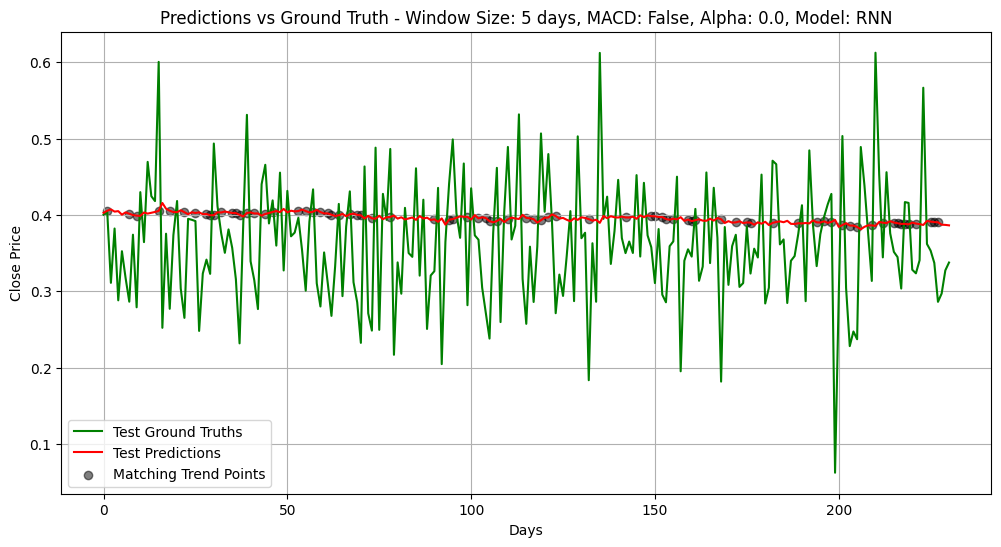

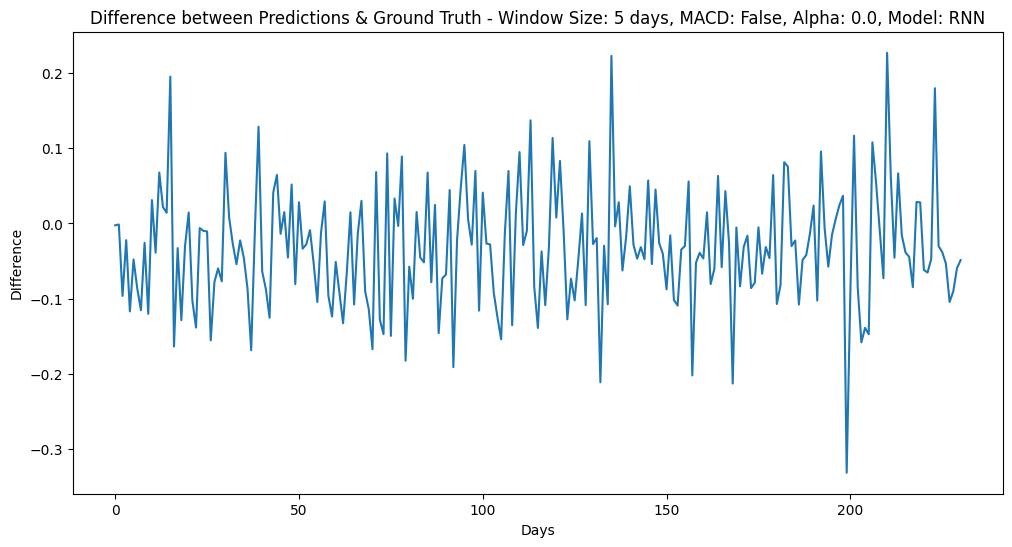

Experiment - Window Size: 5 days, MACD: False, Alpha: 0.0, Model: LSTM
Epoch 1/10, Train Loss: 0.0981, Val Loss: 0.0648
Epoch 2/10, Train Loss: 0.0550, Val Loss: 0.0209
Epoch 3/10, Train Loss: 0.0221, Val Loss: 0.0055
Epoch 4/10, Train Loss: 0.0070, Val Loss: 0.0140
Epoch 5/10, Train Loss: 0.0046, Val Loss: 0.0136
Epoch 6/10, Train Loss: 0.0043, Val Loss: 0.0112
Epoch 7/10, Train Loss: 0.0041, Val Loss: 0.0092
Epoch 8/10, Train Loss: 0.0040, Val Loss: 0.0077
Epoch 9/10, Train Loss: 0.0039, Val Loss: 0.0065
Epoch 10/10, Train Loss: 0.0038, Val Loss: 0.0056


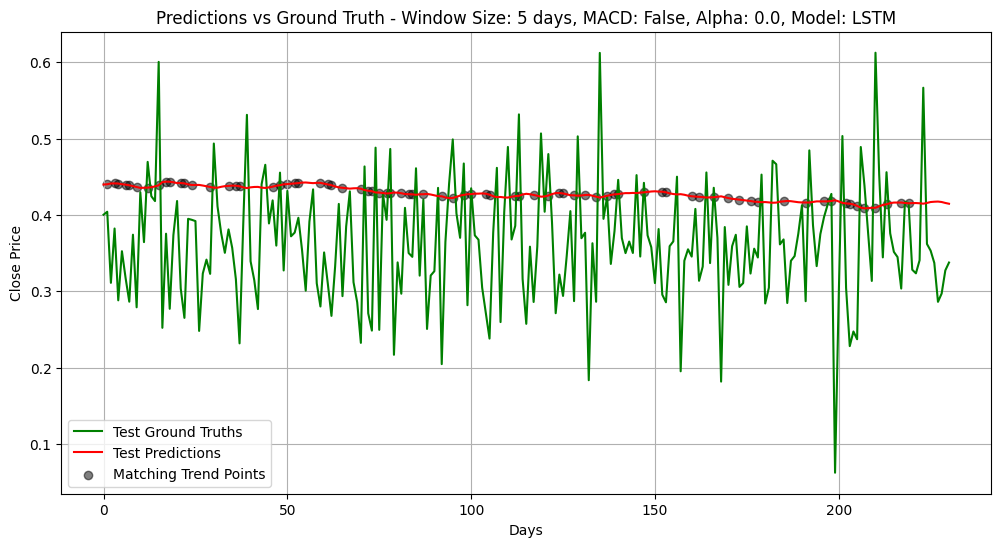

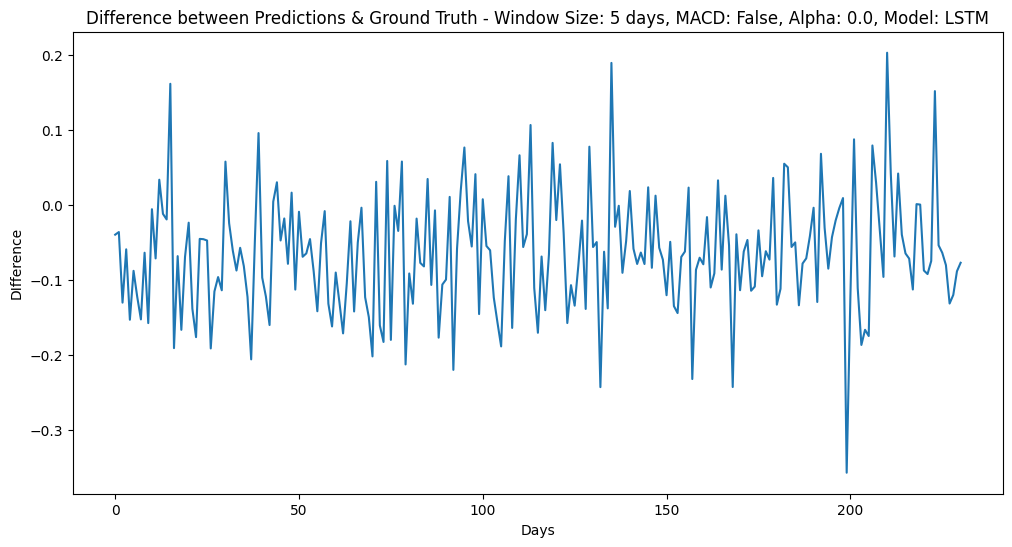

Experiment - Window Size: 5 days, MACD: False, Alpha: 0.9, Model: RNN
Epoch 1/10, Train Loss: 0.0044, Val Loss: 0.0009
Epoch 2/10, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 3/10, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 4/10, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 5/10, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 6/10, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 8/10, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 9/10, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 10/10, Train Loss: 0.0004, Val Loss: 0.0003


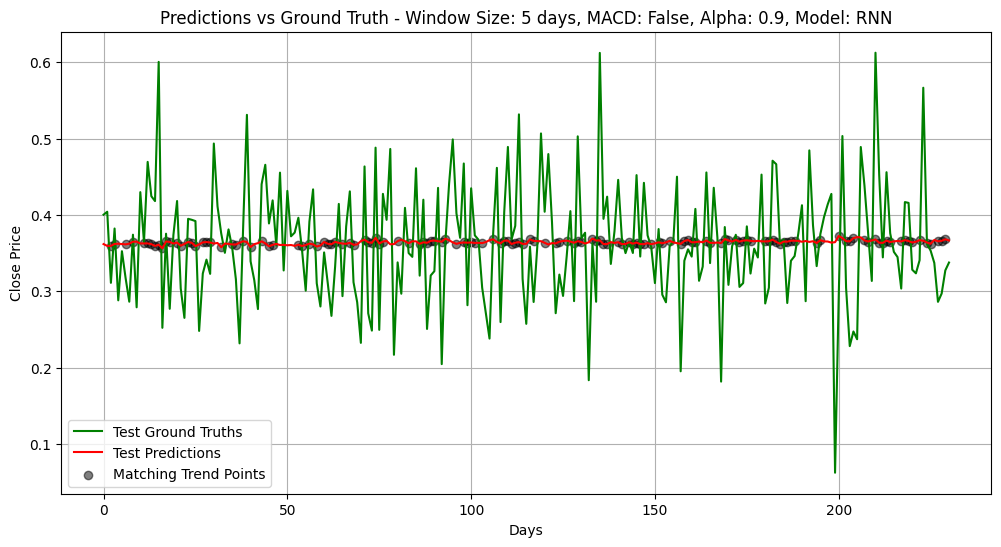

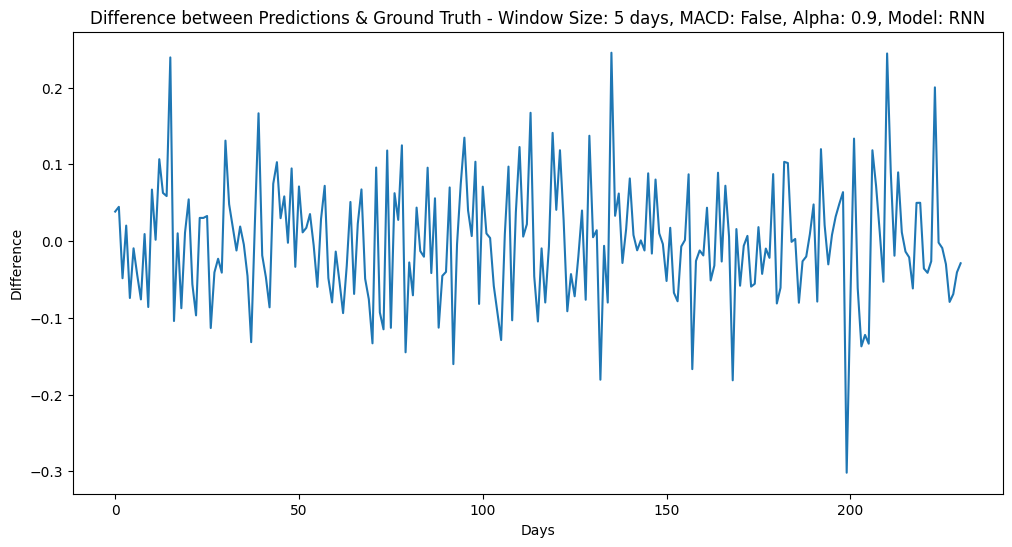

Experiment - Window Size: 5 days, MACD: False, Alpha: 0.9, Model: LSTM
Epoch 1/10, Train Loss: 0.0061, Val Loss: 0.0036
Epoch 2/10, Train Loss: 0.0030, Val Loss: 0.0009
Epoch 3/10, Train Loss: 0.0011, Val Loss: 0.0006
Epoch 4/10, Train Loss: 0.0005, Val Loss: 0.0009
Epoch 5/10, Train Loss: 0.0004, Val Loss: 0.0009
Epoch 6/10, Train Loss: 0.0004, Val Loss: 0.0007
Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0006
Epoch 8/10, Train Loss: 0.0004, Val Loss: 0.0005
Epoch 9/10, Train Loss: 0.0004, Val Loss: 0.0005
Epoch 10/10, Train Loss: 0.0004, Val Loss: 0.0004


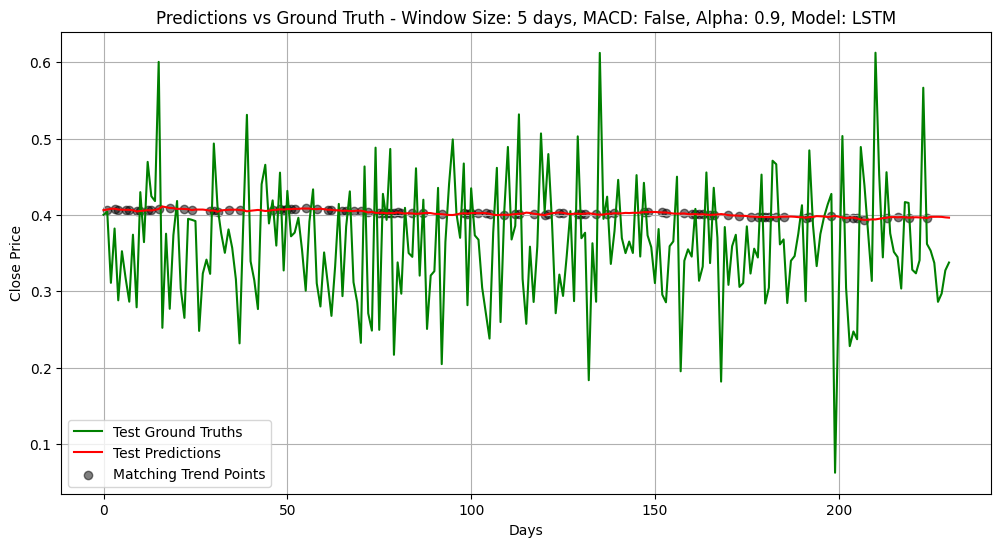

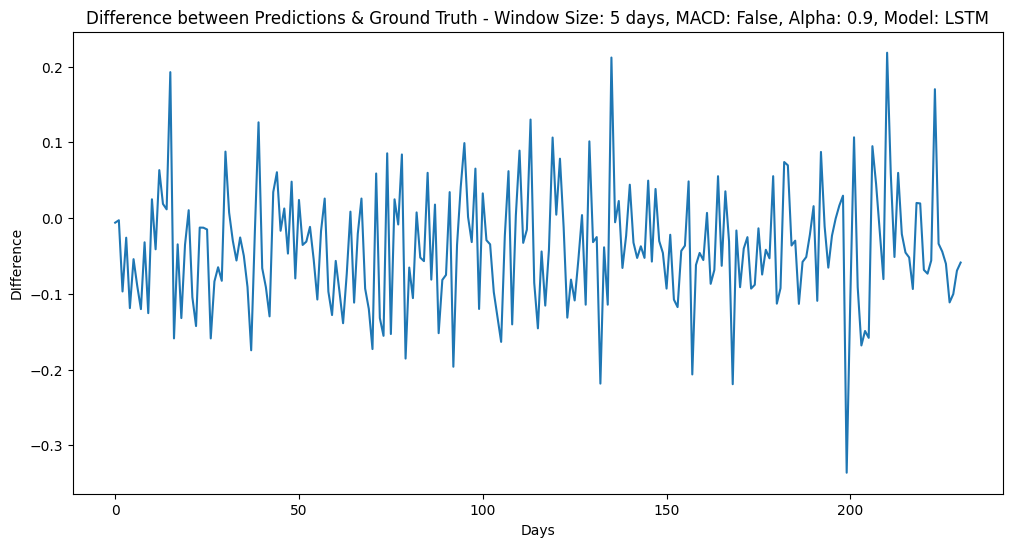

Experiment - Window Size: 5 days, MACD: True, Alpha: 0.0, Model: RNN
Epoch 1/10, Train Loss: 0.0629, Val Loss: 0.0064
Epoch 2/10, Train Loss: 0.0047, Val Loss: 0.0109
Epoch 3/10, Train Loss: 0.0040, Val Loss: 0.0090
Epoch 4/10, Train Loss: 0.0039, Val Loss: 0.0078
Epoch 5/10, Train Loss: 0.0038, Val Loss: 0.0069
Epoch 6/10, Train Loss: 0.0038, Val Loss: 0.0063
Epoch 7/10, Train Loss: 0.0037, Val Loss: 0.0058
Epoch 8/10, Train Loss: 0.0037, Val Loss: 0.0055
Epoch 9/10, Train Loss: 0.0037, Val Loss: 0.0052
Epoch 10/10, Train Loss: 0.0037, Val Loss: 0.0050


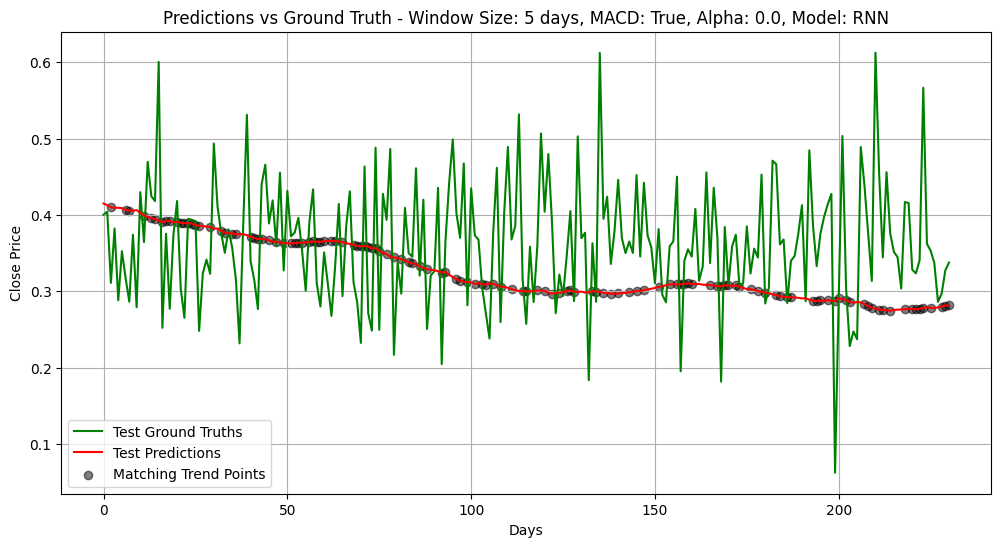

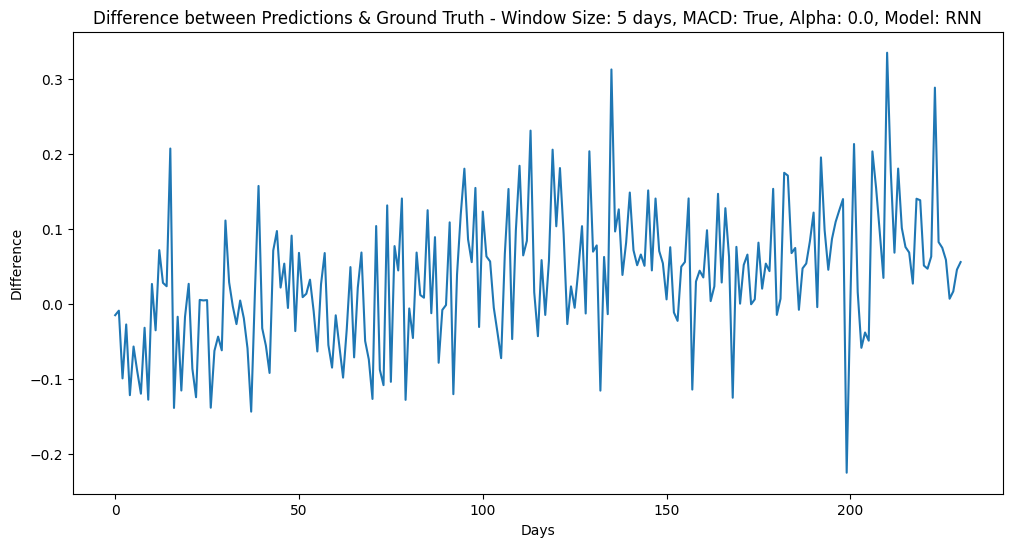

Experiment - Window Size: 5 days, MACD: True, Alpha: 0.0, Model: LSTM
Epoch 1/10, Train Loss: 0.0834, Val Loss: 0.0427
Epoch 2/10, Train Loss: 0.0387, Val Loss: 0.0081
Epoch 3/10, Train Loss: 0.0106, Val Loss: 0.0184
Epoch 4/10, Train Loss: 0.0047, Val Loss: 0.0202
Epoch 5/10, Train Loss: 0.0043, Val Loss: 0.0169
Epoch 6/10, Train Loss: 0.0041, Val Loss: 0.0142
Epoch 7/10, Train Loss: 0.0040, Val Loss: 0.0120
Epoch 8/10, Train Loss: 0.0039, Val Loss: 0.0103
Epoch 9/10, Train Loss: 0.0039, Val Loss: 0.0090
Epoch 10/10, Train Loss: 0.0038, Val Loss: 0.0080


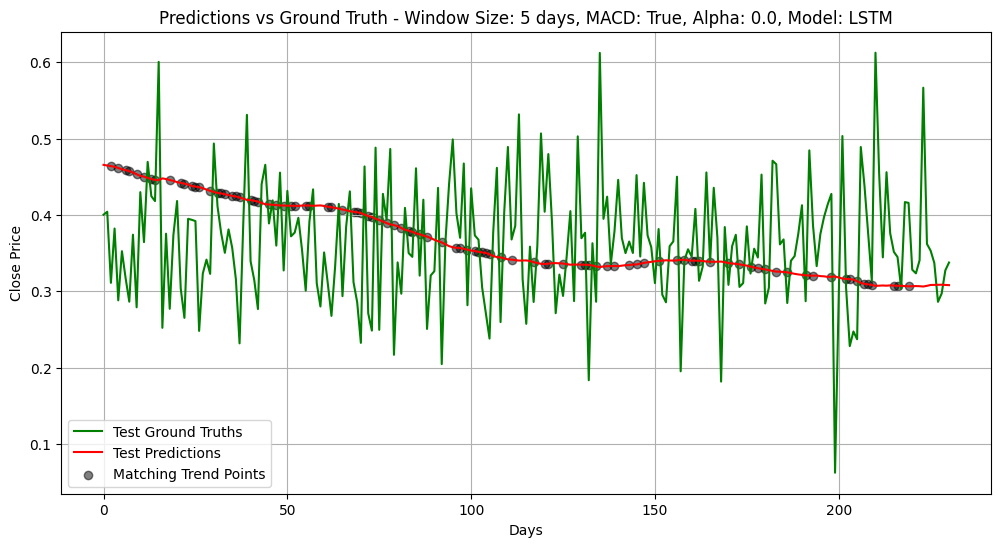

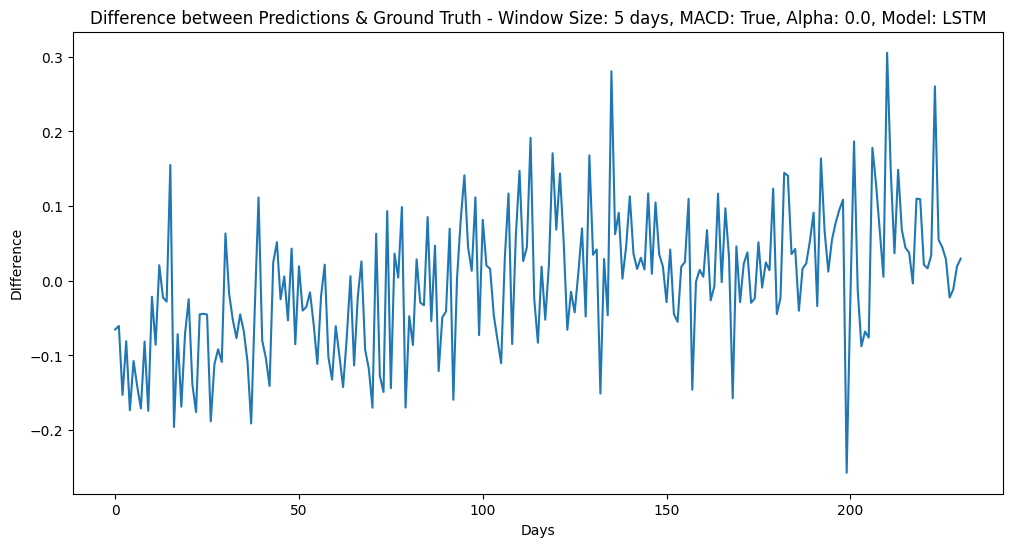

Experiment - Window Size: 5 days, MACD: True, Alpha: 0.9, Model: RNN
Epoch 1/10, Train Loss: 0.0014, Val Loss: 0.0012
Epoch 2/10, Train Loss: 0.0005, Val Loss: 0.0008
Epoch 3/10, Train Loss: 0.0004, Val Loss: 0.0007
Epoch 4/10, Train Loss: 0.0004, Val Loss: 0.0005
Epoch 5/10, Train Loss: 0.0004, Val Loss: 0.0005
Epoch 6/10, Train Loss: 0.0004, Val Loss: 0.0004
Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0004
Epoch 8/10, Train Loss: 0.0004, Val Loss: 0.0004
Epoch 9/10, Train Loss: 0.0004, Val Loss: 0.0004
Epoch 10/10, Train Loss: 0.0004, Val Loss: 0.0004


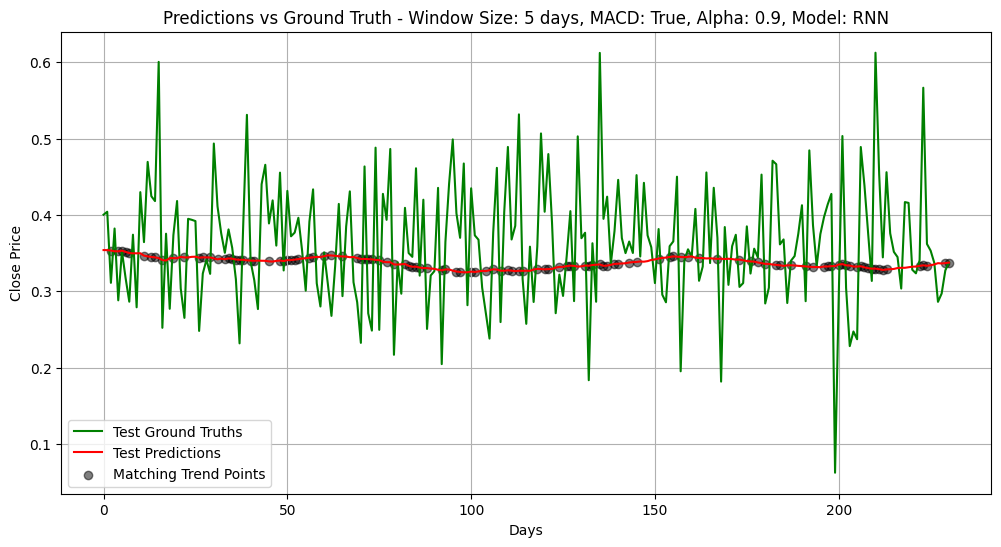

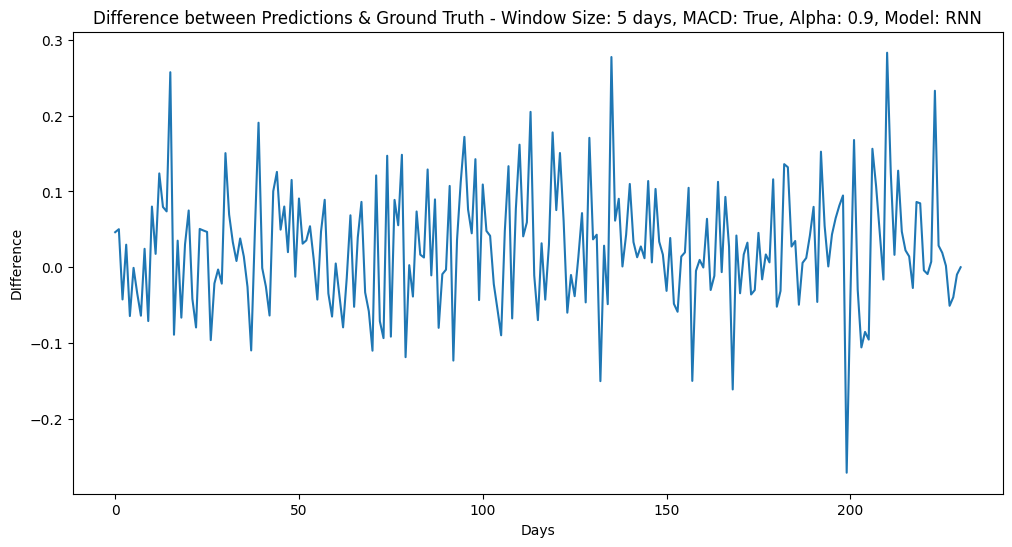

Experiment - Window Size: 5 days, MACD: True, Alpha: 0.9, Model: LSTM
Epoch 1/10, Train Loss: 0.0196, Val Loss: 0.0118
Epoch 2/10, Train Loss: 0.0112, Val Loss: 0.0030
Epoch 3/10, Train Loss: 0.0039, Val Loss: 0.0035
Epoch 4/10, Train Loss: 0.0010, Val Loss: 0.0068
Epoch 5/10, Train Loss: 0.0007, Val Loss: 0.0060
Epoch 6/10, Train Loss: 0.0006, Val Loss: 0.0051
Epoch 7/10, Train Loss: 0.0006, Val Loss: 0.0044
Epoch 8/10, Train Loss: 0.0005, Val Loss: 0.0037
Epoch 9/10, Train Loss: 0.0005, Val Loss: 0.0032
Epoch 10/10, Train Loss: 0.0005, Val Loss: 0.0028


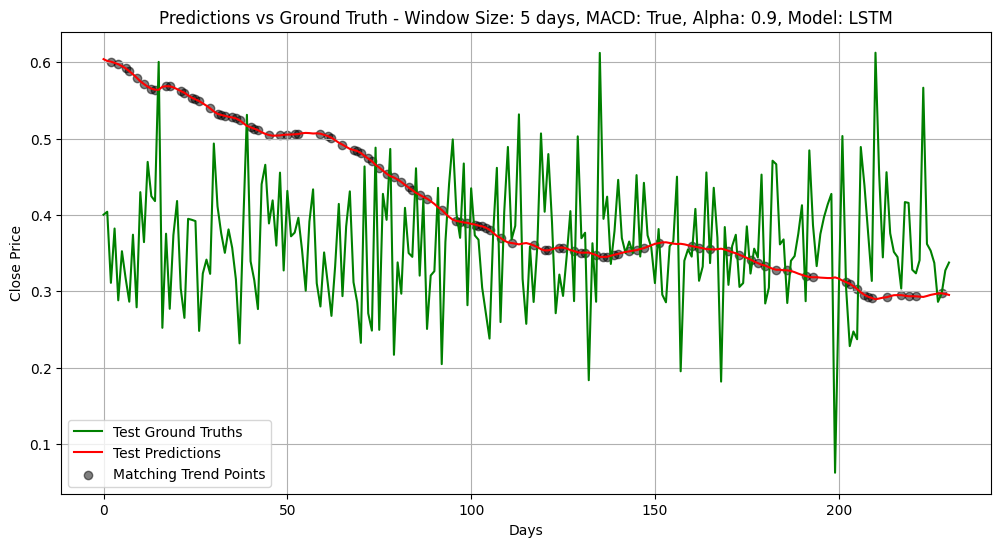

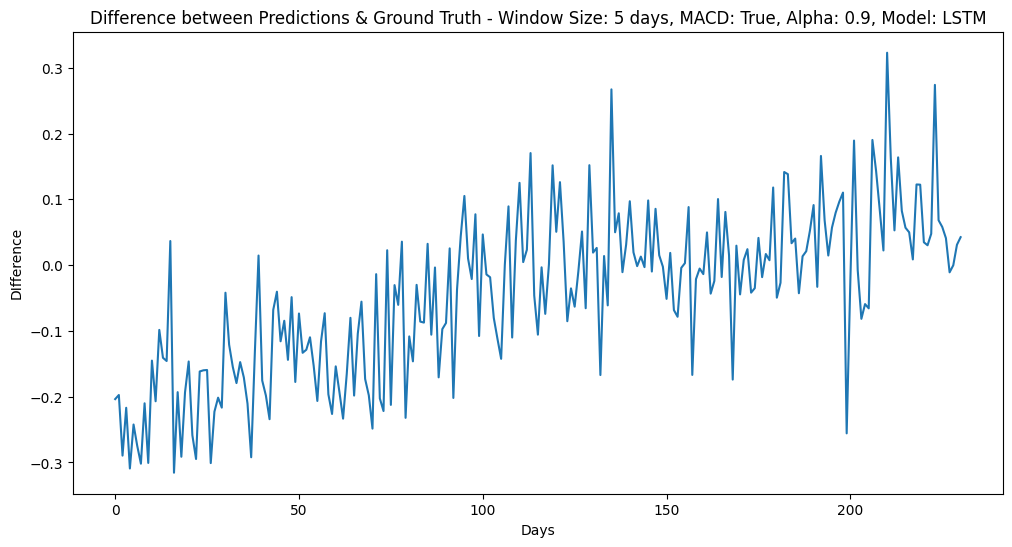

Experiment - Window Size: 50 days, MACD: False, Alpha: 0.0, Model: RNN
Epoch 1/10, Train Loss: 0.1532, Val Loss: 0.0059
Epoch 2/10, Train Loss: 0.0058, Val Loss: 0.0096
Epoch 3/10, Train Loss: 0.0041, Val Loss: 0.0075
Epoch 4/10, Train Loss: 0.0039, Val Loss: 0.0061
Epoch 5/10, Train Loss: 0.0038, Val Loss: 0.0051
Epoch 6/10, Train Loss: 0.0037, Val Loss: 0.0044
Epoch 7/10, Train Loss: 0.0036, Val Loss: 0.0040
Epoch 8/10, Train Loss: 0.0036, Val Loss: 0.0037
Epoch 9/10, Train Loss: 0.0036, Val Loss: 0.0036
Epoch 10/10, Train Loss: 0.0035, Val Loss: 0.0035


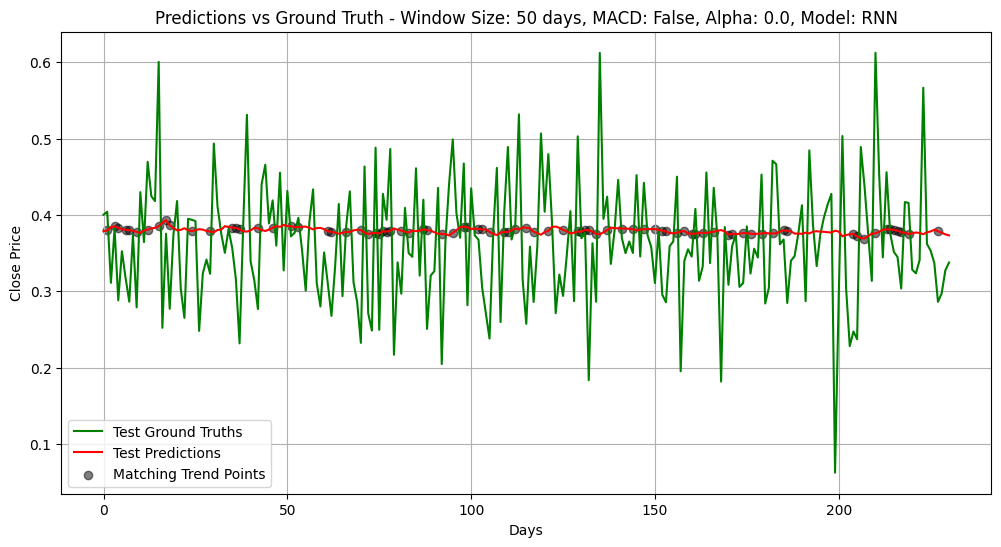

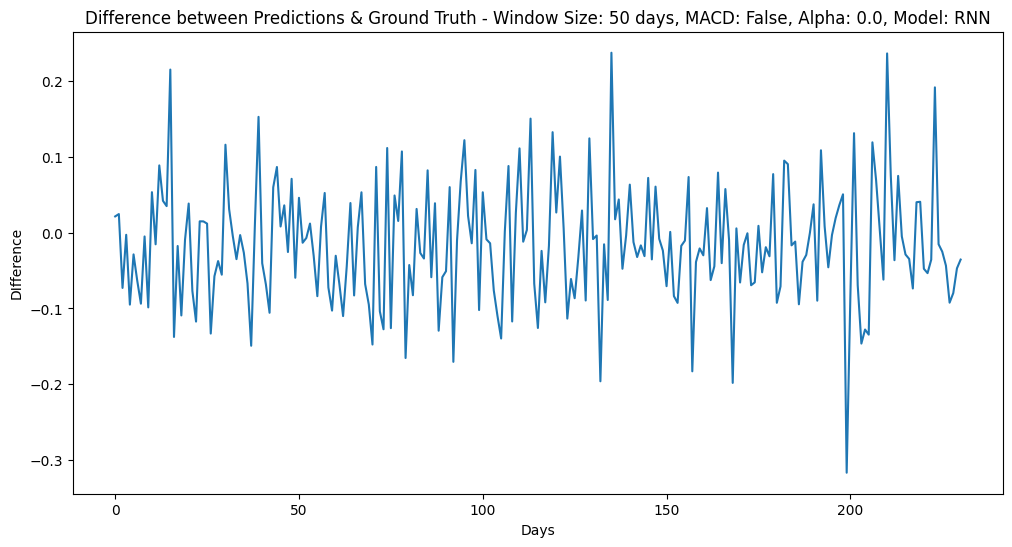

Experiment - Window Size: 50 days, MACD: False, Alpha: 0.0, Model: LSTM
Epoch 1/10, Train Loss: 0.1440, Val Loss: 0.1025
Epoch 2/10, Train Loss: 0.0683, Val Loss: 0.0100
Epoch 3/10, Train Loss: 0.0082, Val Loss: 0.0105
Epoch 4/10, Train Loss: 0.0042, Val Loss: 0.0086
Epoch 5/10, Train Loss: 0.0040, Val Loss: 0.0071
Epoch 6/10, Train Loss: 0.0039, Val Loss: 0.0060
Epoch 7/10, Train Loss: 0.0038, Val Loss: 0.0052
Epoch 8/10, Train Loss: 0.0037, Val Loss: 0.0046
Epoch 9/10, Train Loss: 0.0036, Val Loss: 0.0042
Epoch 10/10, Train Loss: 0.0036, Val Loss: 0.0039


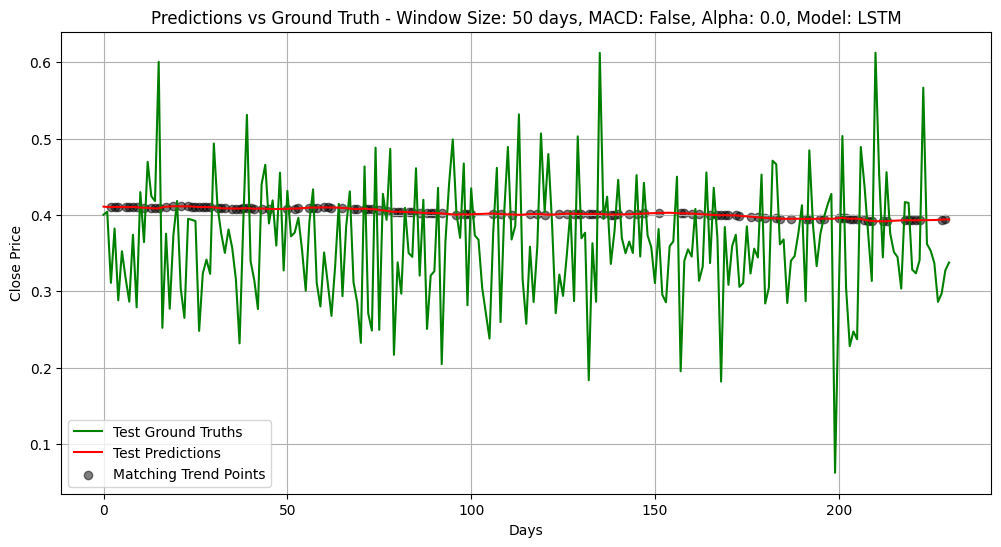

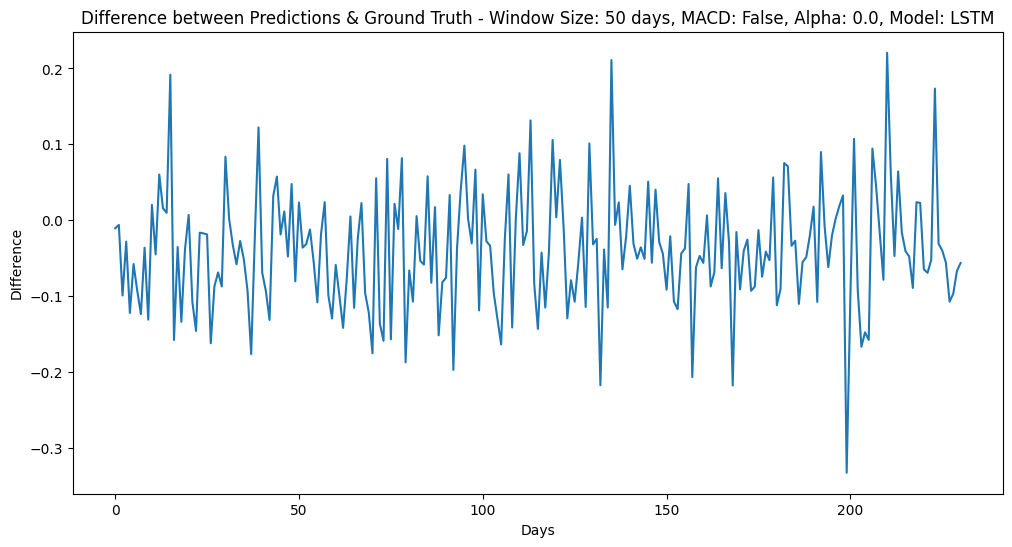

Experiment - Window Size: 50 days, MACD: False, Alpha: 0.9, Model: RNN
Epoch 1/10, Train Loss: 0.0096, Val Loss: 0.0030
Epoch 2/10, Train Loss: 0.0004, Val Loss: 0.0008
Epoch 3/10, Train Loss: 0.0003, Val Loss: 0.0007
Epoch 4/10, Train Loss: 0.0003, Val Loss: 0.0007
Epoch 5/10, Train Loss: 0.0003, Val Loss: 0.0007
Epoch 6/10, Train Loss: 0.0003, Val Loss: 0.0006
Epoch 7/10, Train Loss: 0.0003, Val Loss: 0.0006
Epoch 8/10, Train Loss: 0.0003, Val Loss: 0.0006
Epoch 9/10, Train Loss: 0.0003, Val Loss: 0.0006
Epoch 10/10, Train Loss: 0.0003, Val Loss: 0.0006


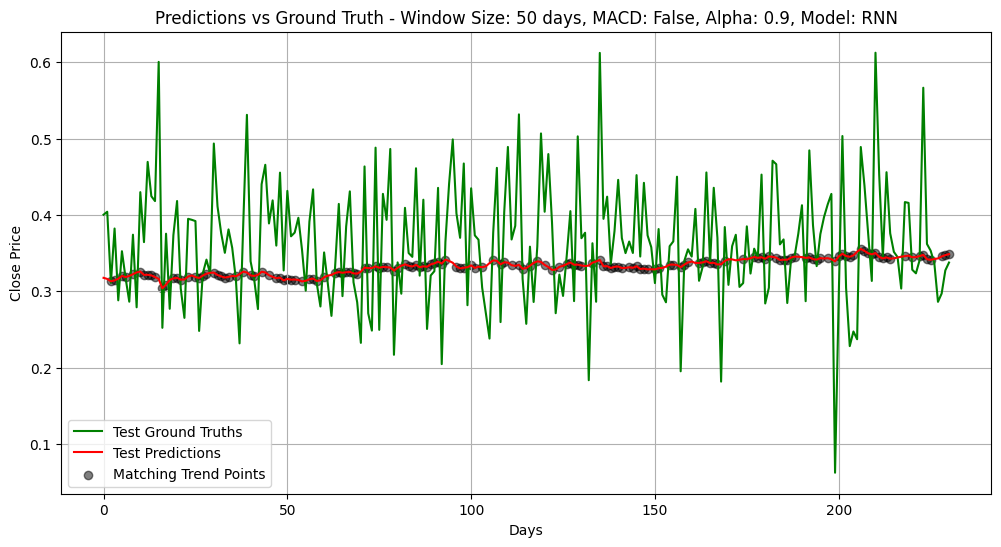

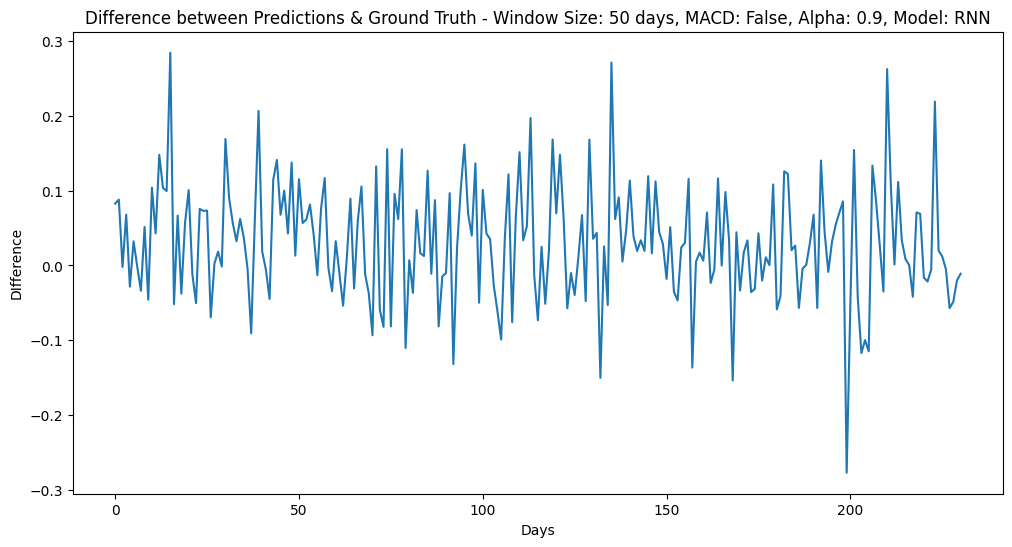

Experiment - Window Size: 50 days, MACD: False, Alpha: 0.9, Model: LSTM
Epoch 1/10, Train Loss: 0.0105, Val Loss: 0.0087
Epoch 2/10, Train Loss: 0.0047, Val Loss: 0.0008
Epoch 3/10, Train Loss: 0.0006, Val Loss: 0.0004
Epoch 4/10, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 5/10, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 6/10, Train Loss: 0.0004, Val Loss: 0.0002
Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 8/10, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 9/10, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 10/10, Train Loss: 0.0004, Val Loss: 0.0003


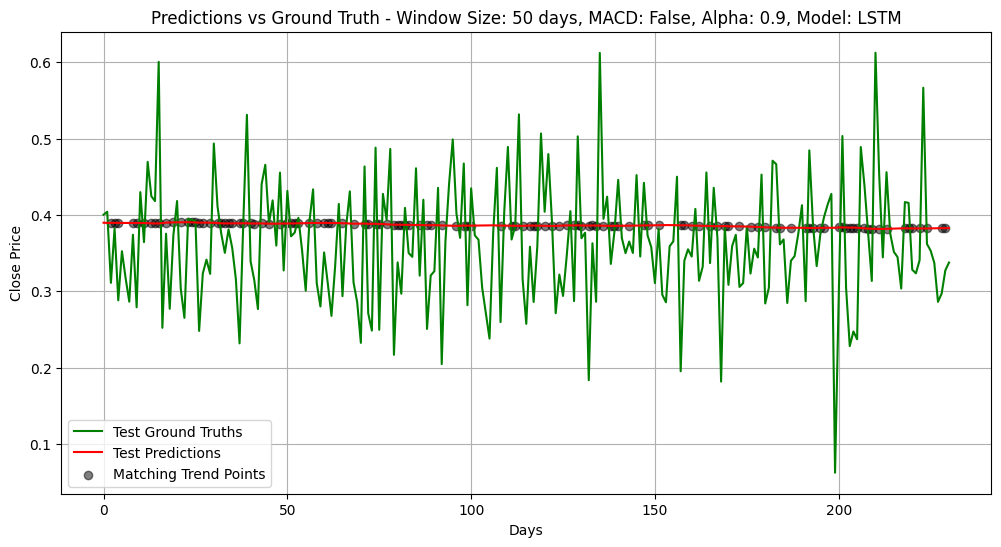

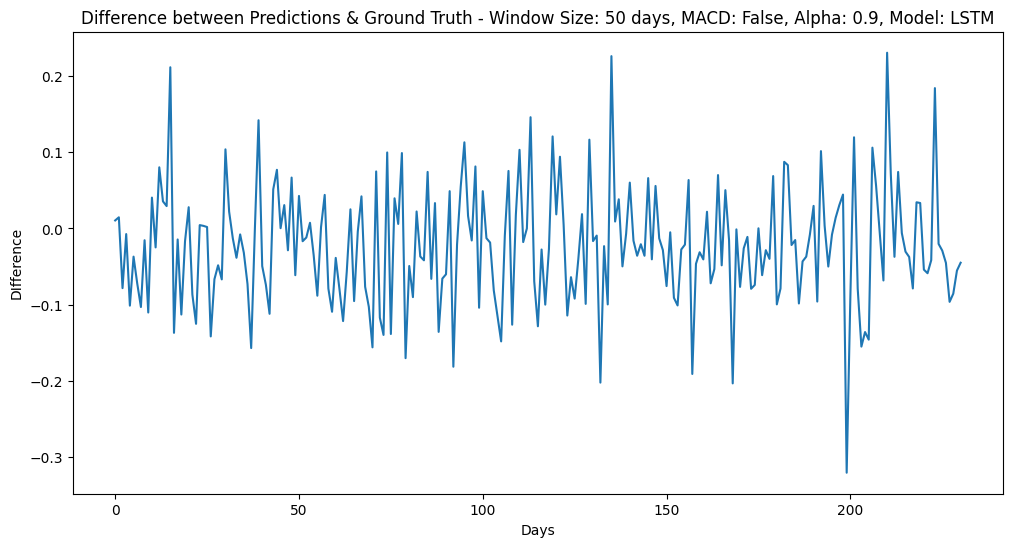

Experiment - Window Size: 50 days, MACD: True, Alpha: 0.0, Model: RNN
Epoch 1/10, Train Loss: 0.0997, Val Loss: 0.0088
Epoch 2/10, Train Loss: 0.0061, Val Loss: 0.0141
Epoch 3/10, Train Loss: 0.0048, Val Loss: 0.0114
Epoch 4/10, Train Loss: 0.0044, Val Loss: 0.0096
Epoch 5/10, Train Loss: 0.0042, Val Loss: 0.0082
Epoch 6/10, Train Loss: 0.0040, Val Loss: 0.0072
Epoch 7/10, Train Loss: 0.0038, Val Loss: 0.0064
Epoch 8/10, Train Loss: 0.0038, Val Loss: 0.0058
Epoch 9/10, Train Loss: 0.0037, Val Loss: 0.0054
Epoch 10/10, Train Loss: 0.0037, Val Loss: 0.0051


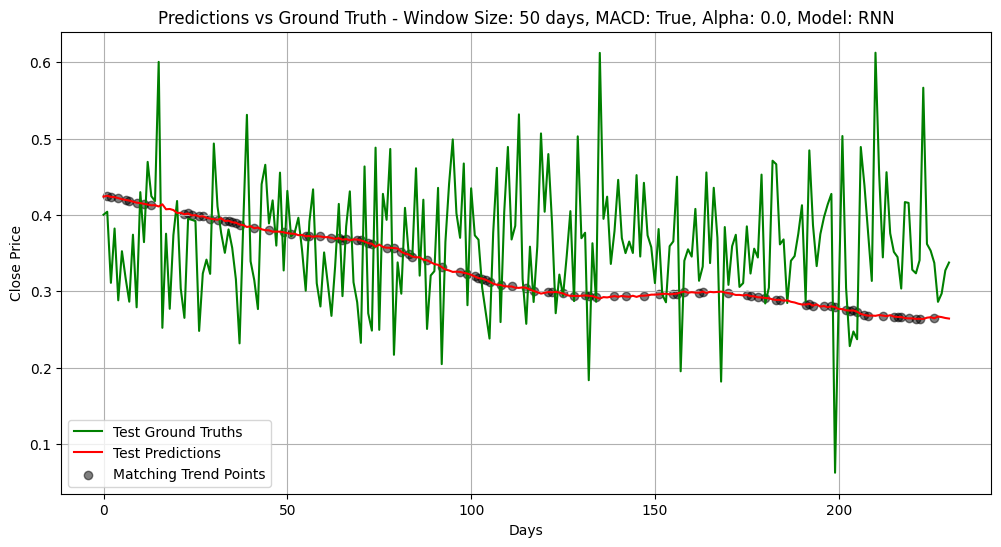

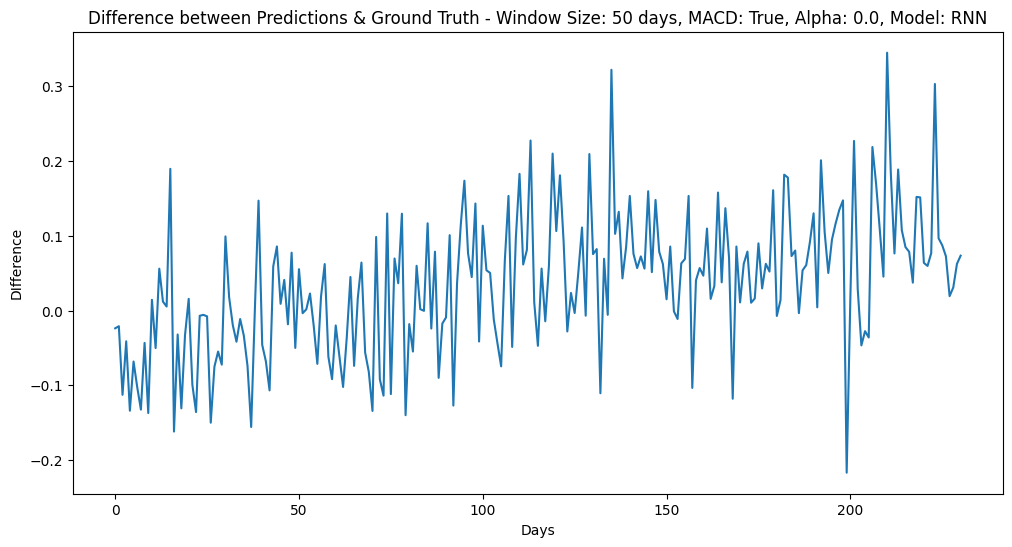

Experiment - Window Size: 50 days, MACD: True, Alpha: 0.0, Model: LSTM
Epoch 1/10, Train Loss: 0.1509, Val Loss: 0.0709
Epoch 2/10, Train Loss: 0.0744, Val Loss: 0.0112
Epoch 3/10, Train Loss: 0.0151, Val Loss: 0.0448
Epoch 4/10, Train Loss: 0.0068, Val Loss: 0.0370
Epoch 5/10, Train Loss: 0.0059, Val Loss: 0.0304
Epoch 6/10, Train Loss: 0.0053, Val Loss: 0.0250
Epoch 7/10, Train Loss: 0.0048, Val Loss: 0.0206
Epoch 8/10, Train Loss: 0.0045, Val Loss: 0.0171
Epoch 9/10, Train Loss: 0.0043, Val Loss: 0.0144
Epoch 10/10, Train Loss: 0.0041, Val Loss: 0.0123


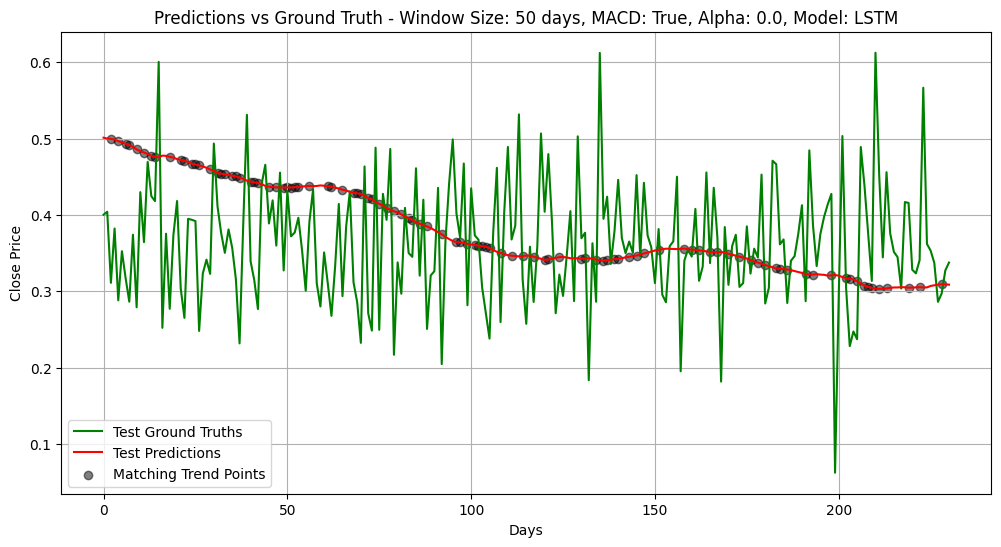

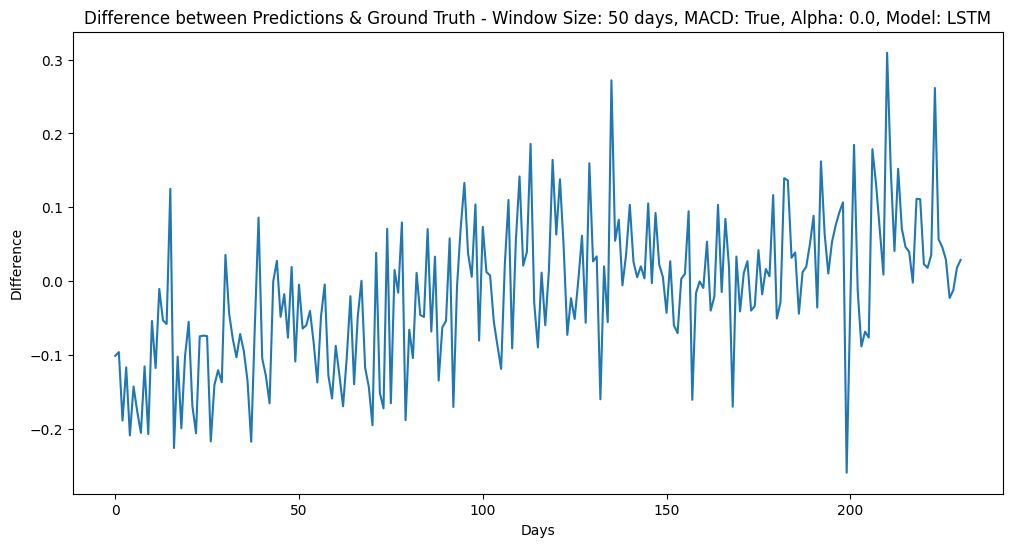

Experiment - Window Size: 50 days, MACD: True, Alpha: 0.9, Model: RNN
Epoch 1/10, Train Loss: 0.0007, Val Loss: 0.0004
Epoch 2/10, Train Loss: 0.0004, Val Loss: 0.0005
Epoch 3/10, Train Loss: 0.0004, Val Loss: 0.0005
Epoch 4/10, Train Loss: 0.0004, Val Loss: 0.0006
Epoch 5/10, Train Loss: 0.0004, Val Loss: 0.0006
Epoch 6/10, Train Loss: 0.0003, Val Loss: 0.0006
Epoch 7/10, Train Loss: 0.0003, Val Loss: 0.0007
Epoch 8/10, Train Loss: 0.0003, Val Loss: 0.0007
Epoch 9/10, Train Loss: 0.0003, Val Loss: 0.0007
Epoch 10/10, Train Loss: 0.0003, Val Loss: 0.0007


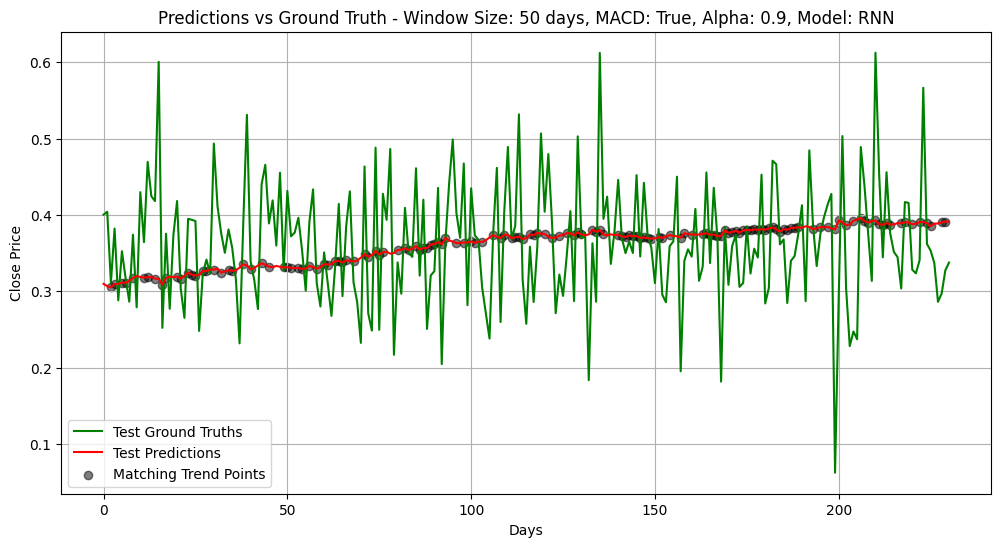

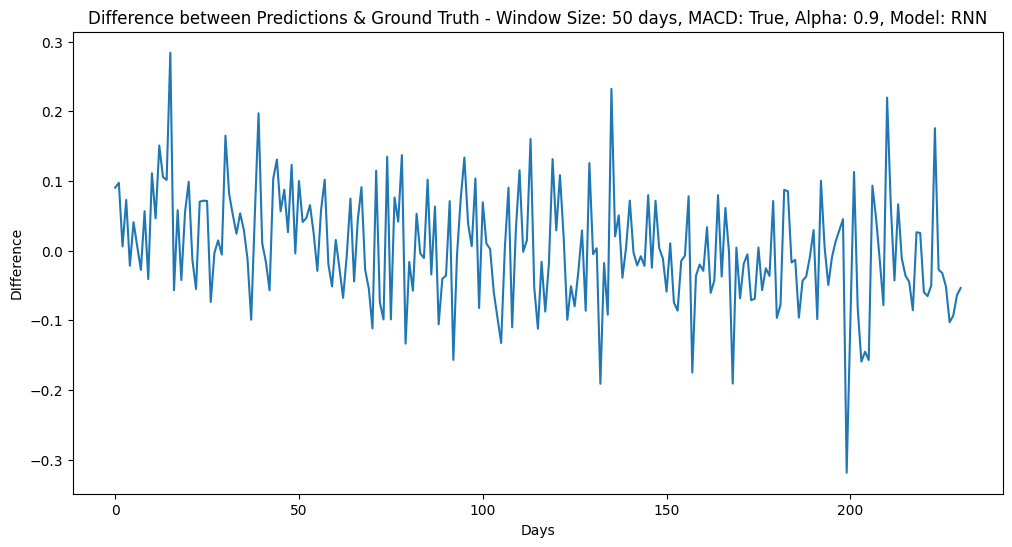

Experiment - Window Size: 50 days, MACD: True, Alpha: 0.9, Model: LSTM
Epoch 1/10, Train Loss: 0.0080, Val Loss: 0.0035
Epoch 2/10, Train Loss: 0.0033, Val Loss: 0.0005
Epoch 3/10, Train Loss: 0.0008, Val Loss: 0.0017
Epoch 4/10, Train Loss: 0.0005, Val Loss: 0.0013
Epoch 5/10, Train Loss: 0.0005, Val Loss: 0.0010
Epoch 6/10, Train Loss: 0.0005, Val Loss: 0.0008
Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0006
Epoch 8/10, Train Loss: 0.0004, Val Loss: 0.0005
Epoch 9/10, Train Loss: 0.0004, Val Loss: 0.0004
Epoch 10/10, Train Loss: 0.0004, Val Loss: 0.0004


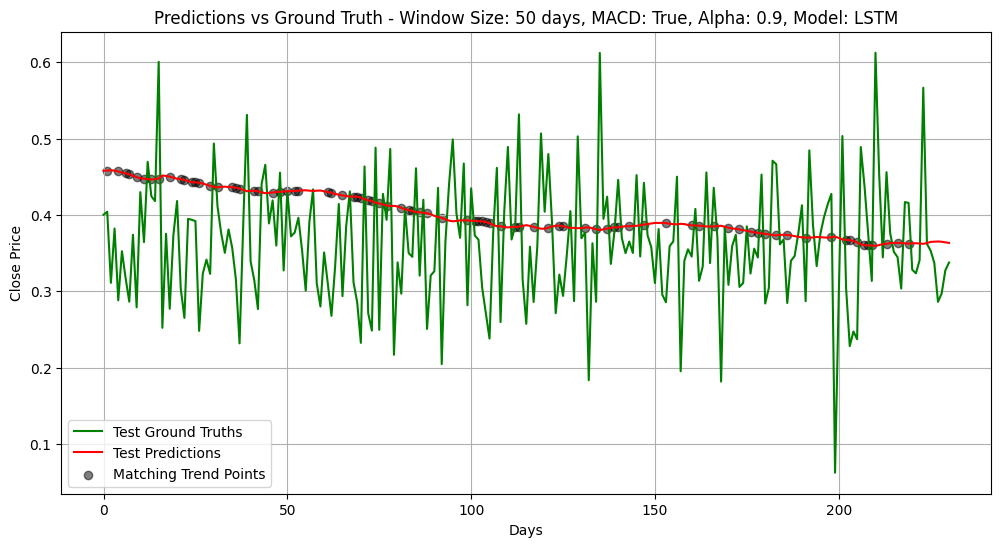

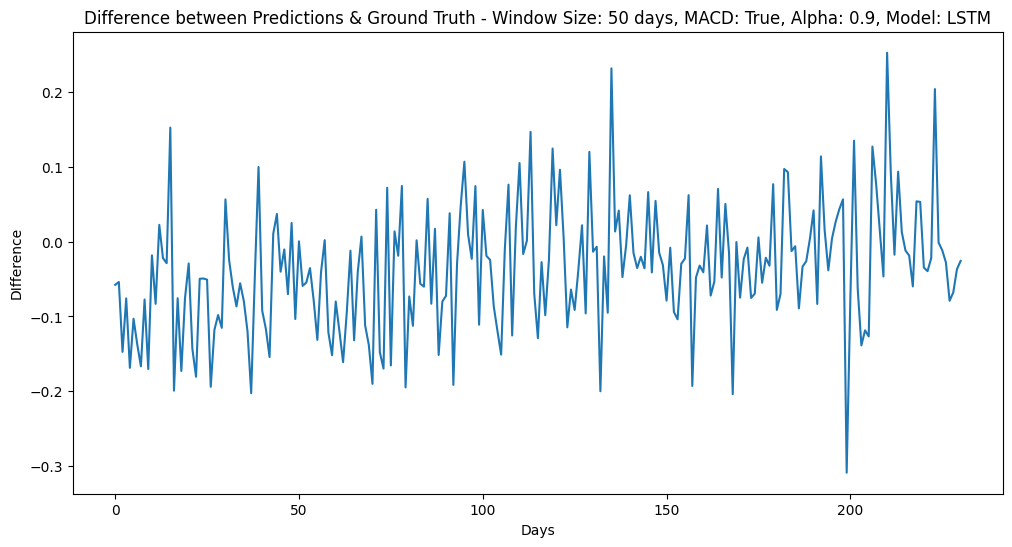

Experiment - Window Size: 100 days, MACD: False, Alpha: 0.0, Model: RNN
Epoch 1/10, Train Loss: 0.0463, Val Loss: 0.0049
Epoch 2/10, Train Loss: 0.0035, Val Loss: 0.0046
Epoch 3/10, Train Loss: 0.0035, Val Loss: 0.0041
Epoch 4/10, Train Loss: 0.0035, Val Loss: 0.0039
Epoch 5/10, Train Loss: 0.0035, Val Loss: 0.0037
Epoch 6/10, Train Loss: 0.0034, Val Loss: 0.0036
Epoch 7/10, Train Loss: 0.0034, Val Loss: 0.0036
Epoch 8/10, Train Loss: 0.0034, Val Loss: 0.0036
Epoch 9/10, Train Loss: 0.0034, Val Loss: 0.0036
Epoch 10/10, Train Loss: 0.0034, Val Loss: 0.0036


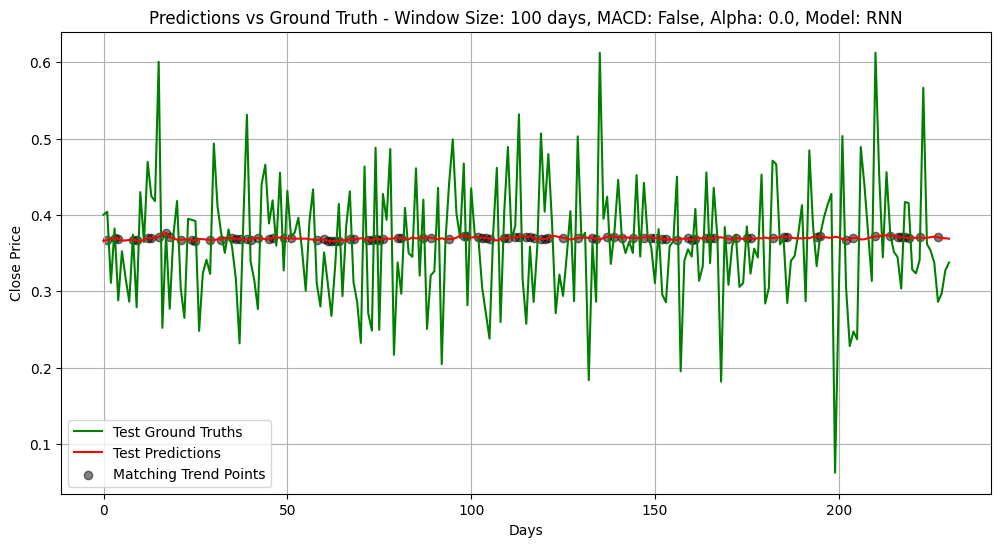

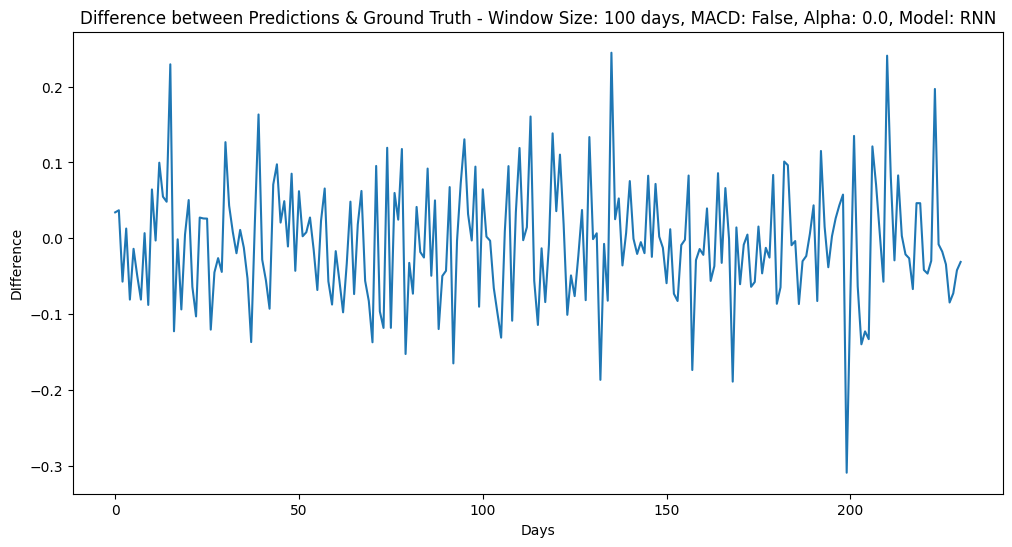

Experiment - Window Size: 100 days, MACD: False, Alpha: 0.0, Model: LSTM
Epoch 1/10, Train Loss: 0.0381, Val Loss: 0.0130
Epoch 2/10, Train Loss: 0.0110, Val Loss: 0.0053
Epoch 3/10, Train Loss: 0.0040, Val Loss: 0.0072
Epoch 4/10, Train Loss: 0.0037, Val Loss: 0.0060
Epoch 5/10, Train Loss: 0.0036, Val Loss: 0.0051
Epoch 6/10, Train Loss: 0.0035, Val Loss: 0.0045
Epoch 7/10, Train Loss: 0.0035, Val Loss: 0.0041
Epoch 8/10, Train Loss: 0.0035, Val Loss: 0.0039
Epoch 9/10, Train Loss: 0.0034, Val Loss: 0.0037
Epoch 10/10, Train Loss: 0.0034, Val Loss: 0.0036


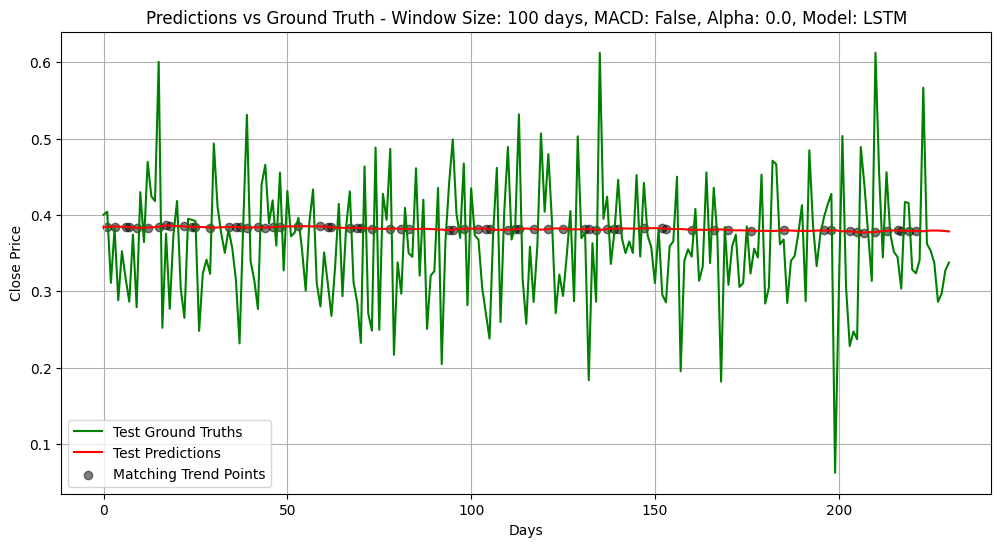

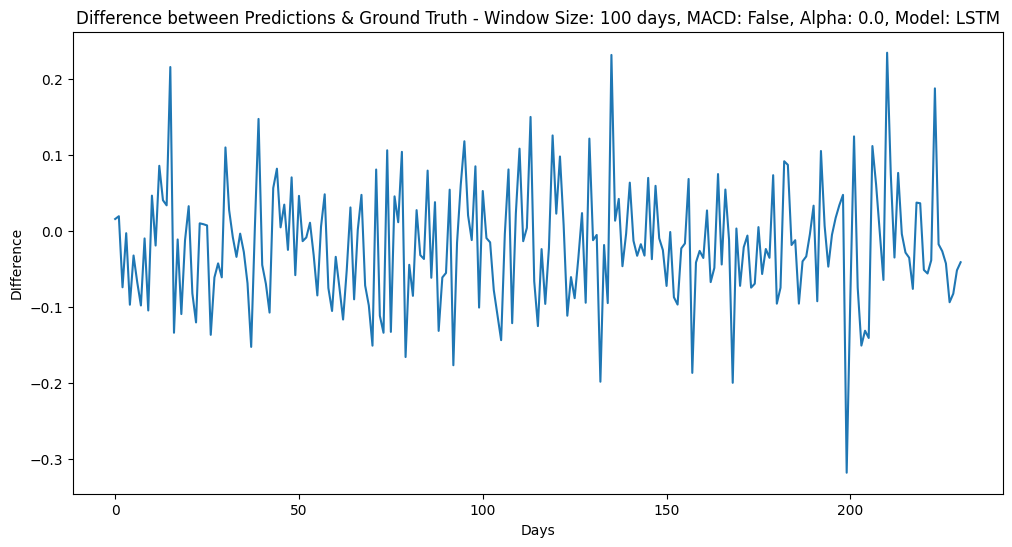

Experiment - Window Size: 100 days, MACD: False, Alpha: 0.9, Model: RNN
Epoch 1/10, Train Loss: 0.0129, Val Loss: 0.0018
Epoch 2/10, Train Loss: 0.0012, Val Loss: 0.0007
Epoch 3/10, Train Loss: 0.0004, Val Loss: 0.0006
Epoch 4/10, Train Loss: 0.0004, Val Loss: 0.0005
Epoch 5/10, Train Loss: 0.0004, Val Loss: 0.0005
Epoch 6/10, Train Loss: 0.0004, Val Loss: 0.0004
Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0004
Epoch 8/10, Train Loss: 0.0004, Val Loss: 0.0004
Epoch 9/10, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 10/10, Train Loss: 0.0003, Val Loss: 0.0003


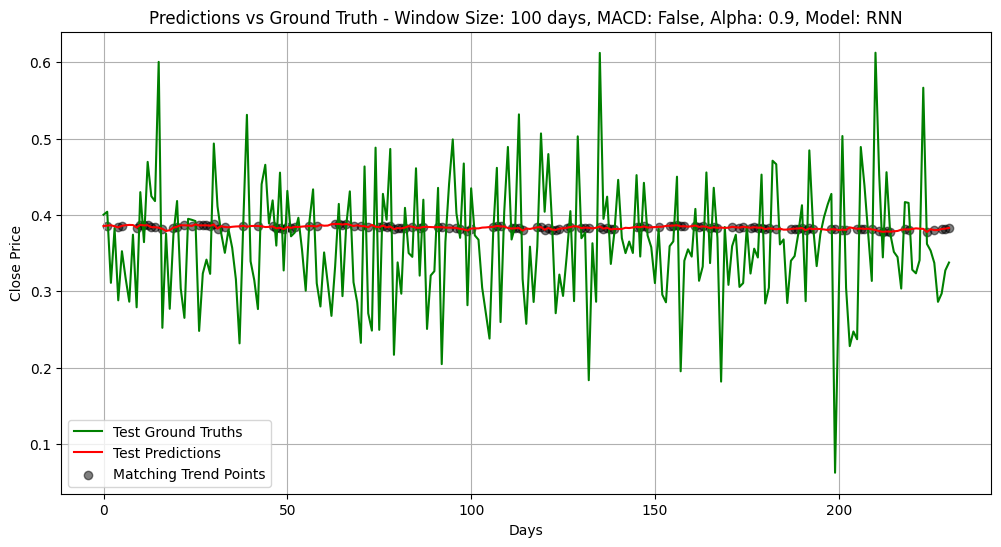

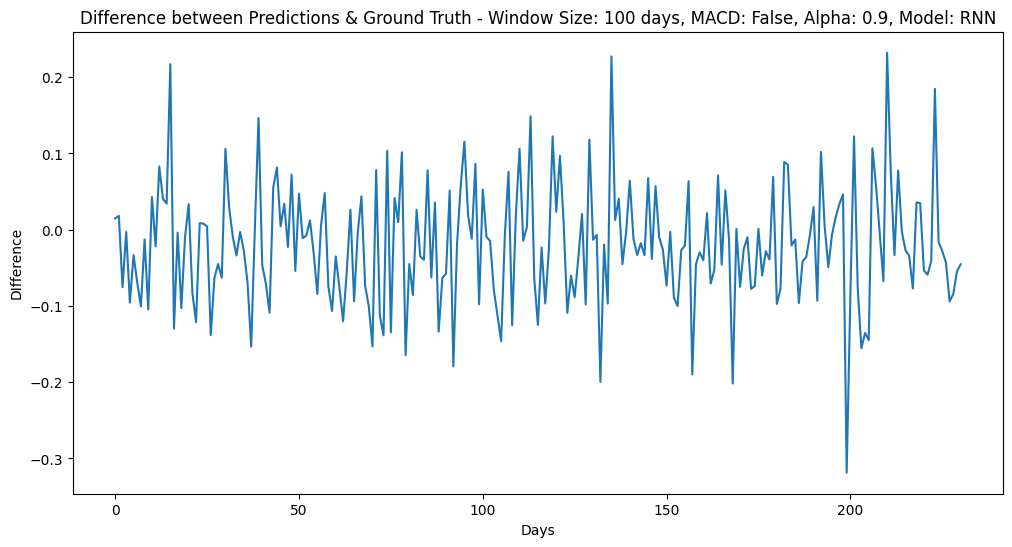

Experiment - Window Size: 100 days, MACD: False, Alpha: 0.9, Model: LSTM
Epoch 1/10, Train Loss: 0.0081, Val Loss: 0.0030
Epoch 2/10, Train Loss: 0.0036, Val Loss: 0.0007
Epoch 3/10, Train Loss: 0.0009, Val Loss: 0.0023
Epoch 4/10, Train Loss: 0.0005, Val Loss: 0.0018
Epoch 5/10, Train Loss: 0.0005, Val Loss: 0.0015
Epoch 6/10, Train Loss: 0.0004, Val Loss: 0.0012
Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0009
Epoch 8/10, Train Loss: 0.0004, Val Loss: 0.0007
Epoch 9/10, Train Loss: 0.0004, Val Loss: 0.0006
Epoch 10/10, Train Loss: 0.0004, Val Loss: 0.0005


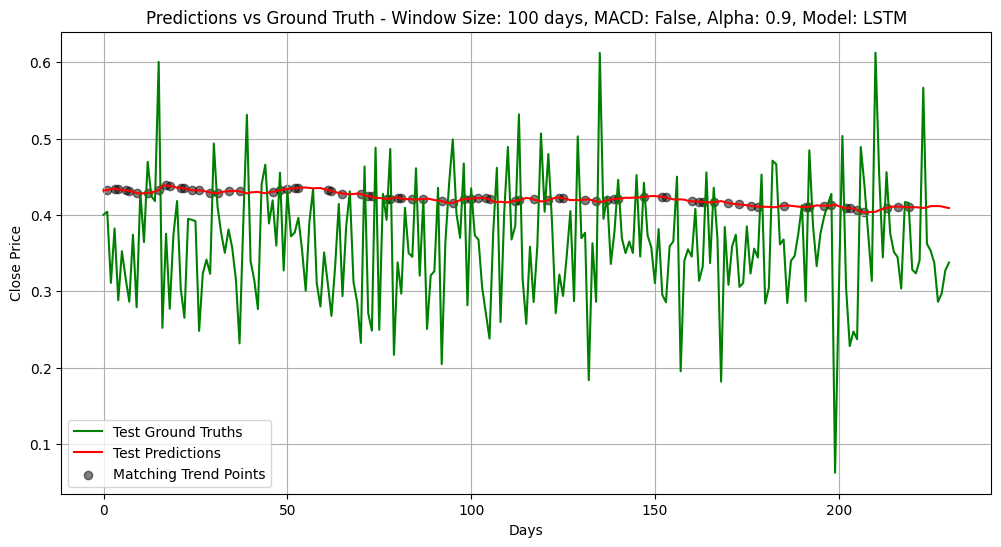

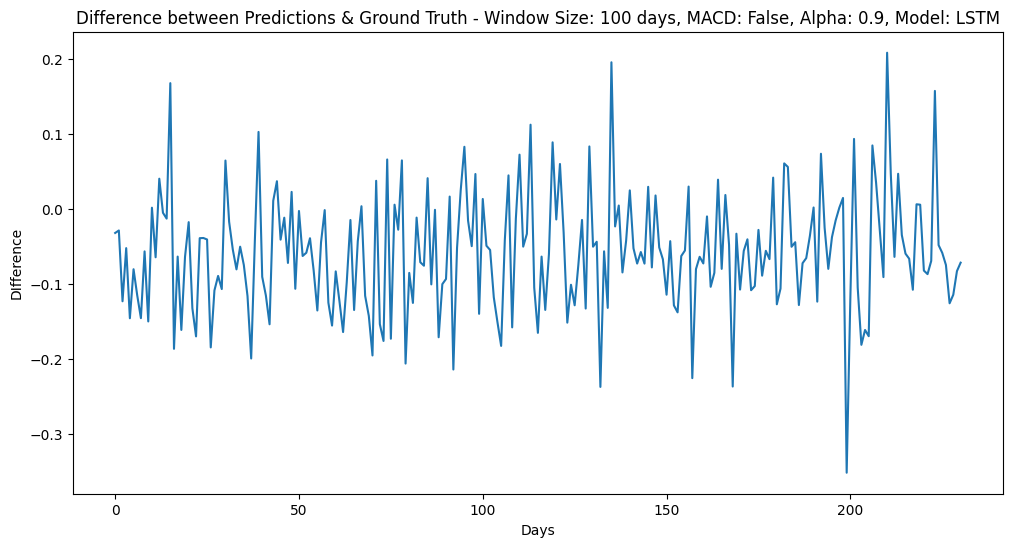

Experiment - Window Size: 100 days, MACD: True, Alpha: 0.0, Model: RNN
Epoch 1/10, Train Loss: 0.0296, Val Loss: 0.0050
Epoch 2/10, Train Loss: 0.0035, Val Loss: 0.0041
Epoch 3/10, Train Loss: 0.0035, Val Loss: 0.0039
Epoch 4/10, Train Loss: 0.0034, Val Loss: 0.0039
Epoch 5/10, Train Loss: 0.0034, Val Loss: 0.0038
Epoch 6/10, Train Loss: 0.0034, Val Loss: 0.0038
Epoch 7/10, Train Loss: 0.0034, Val Loss: 0.0037
Epoch 8/10, Train Loss: 0.0034, Val Loss: 0.0037
Epoch 9/10, Train Loss: 0.0034, Val Loss: 0.0037
Epoch 10/10, Train Loss: 0.0034, Val Loss: 0.0037


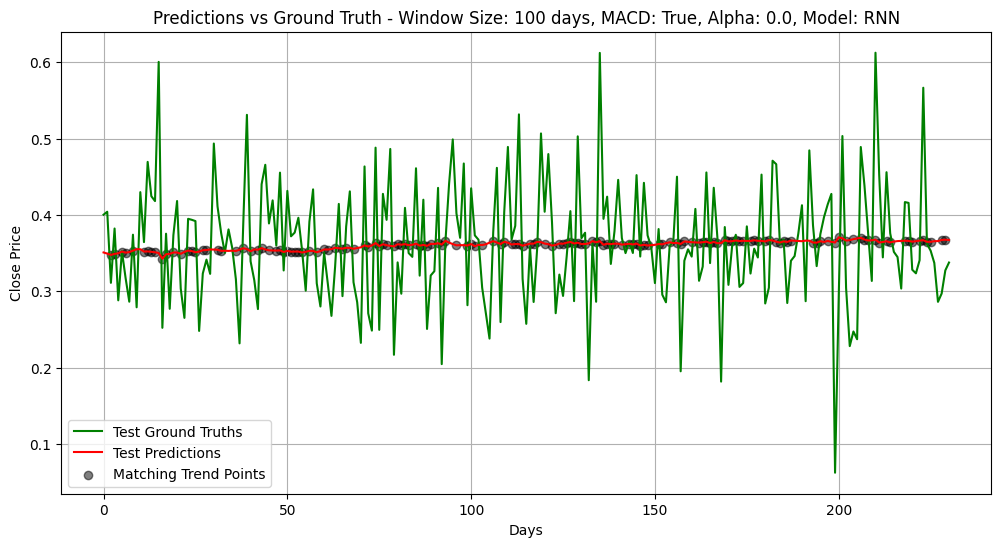

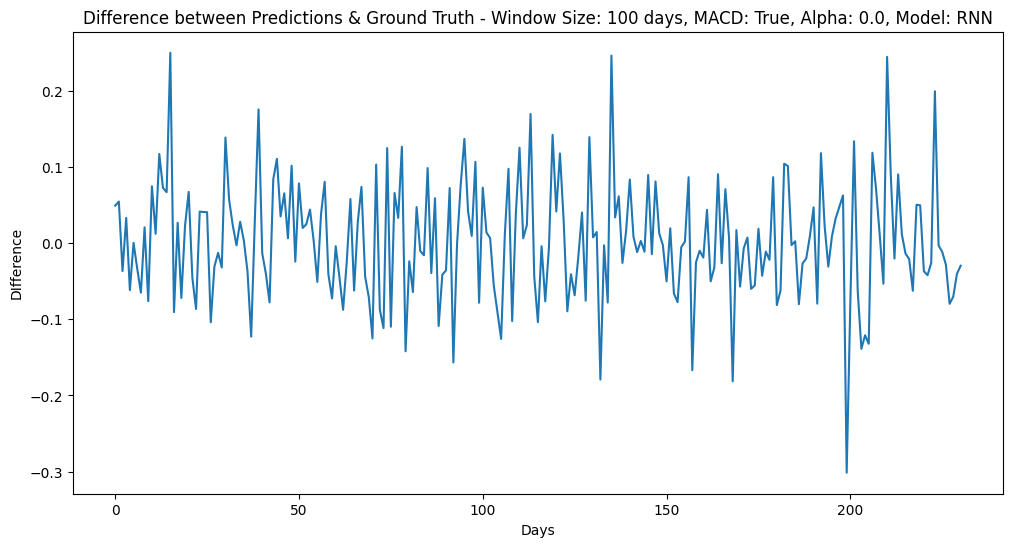

Experiment - Window Size: 100 days, MACD: True, Alpha: 0.0, Model: LSTM
Epoch 1/10, Train Loss: 0.0594, Val Loss: 0.0274
Epoch 2/10, Train Loss: 0.0164, Val Loss: 0.0069
Epoch 3/10, Train Loss: 0.0037, Val Loss: 0.0078
Epoch 4/10, Train Loss: 0.0036, Val Loss: 0.0066
Epoch 5/10, Train Loss: 0.0036, Val Loss: 0.0057
Epoch 6/10, Train Loss: 0.0035, Val Loss: 0.0051
Epoch 7/10, Train Loss: 0.0035, Val Loss: 0.0047
Epoch 8/10, Train Loss: 0.0035, Val Loss: 0.0044
Epoch 9/10, Train Loss: 0.0035, Val Loss: 0.0042
Epoch 10/10, Train Loss: 0.0035, Val Loss: 0.0040


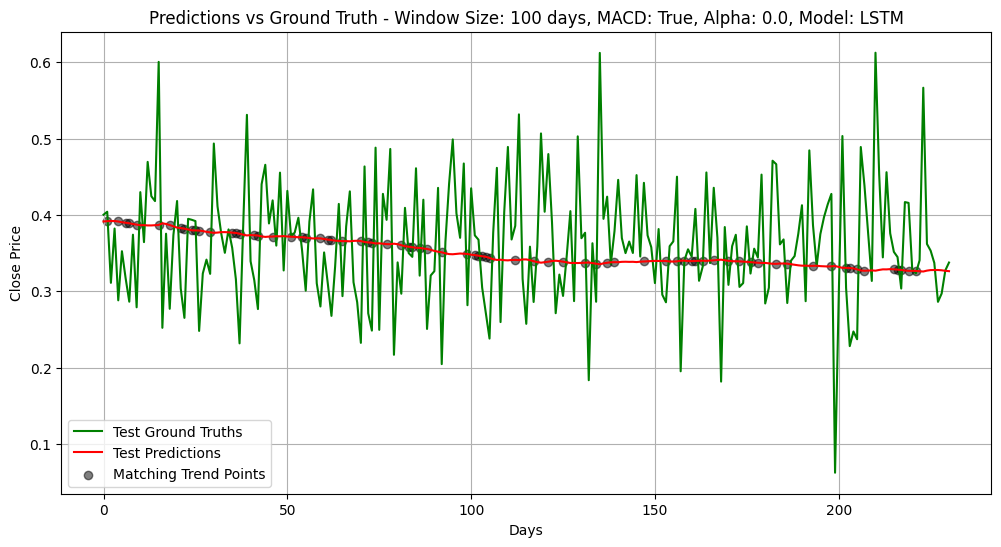

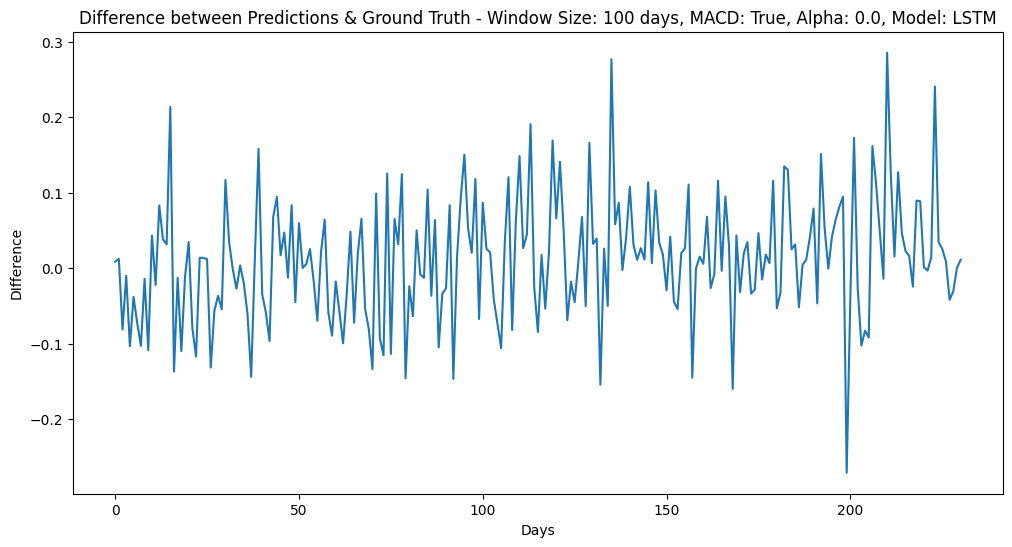

Experiment - Window Size: 100 days, MACD: True, Alpha: 0.9, Model: RNN
Epoch 1/10, Train Loss: 0.0155, Val Loss: 0.0019
Epoch 2/10, Train Loss: 0.0013, Val Loss: 0.0010
Epoch 3/10, Train Loss: 0.0004, Val Loss: 0.0008
Epoch 4/10, Train Loss: 0.0004, Val Loss: 0.0006
Epoch 5/10, Train Loss: 0.0004, Val Loss: 0.0005
Epoch 6/10, Train Loss: 0.0004, Val Loss: 0.0005
Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0004
Epoch 8/10, Train Loss: 0.0004, Val Loss: 0.0004
Epoch 9/10, Train Loss: 0.0003, Val Loss: 0.0004
Epoch 10/10, Train Loss: 0.0003, Val Loss: 0.0003


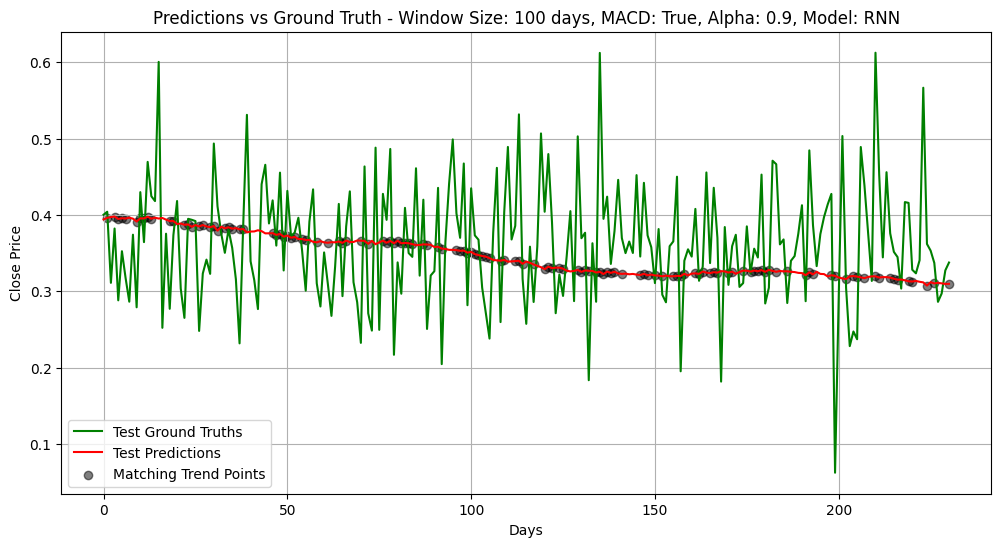

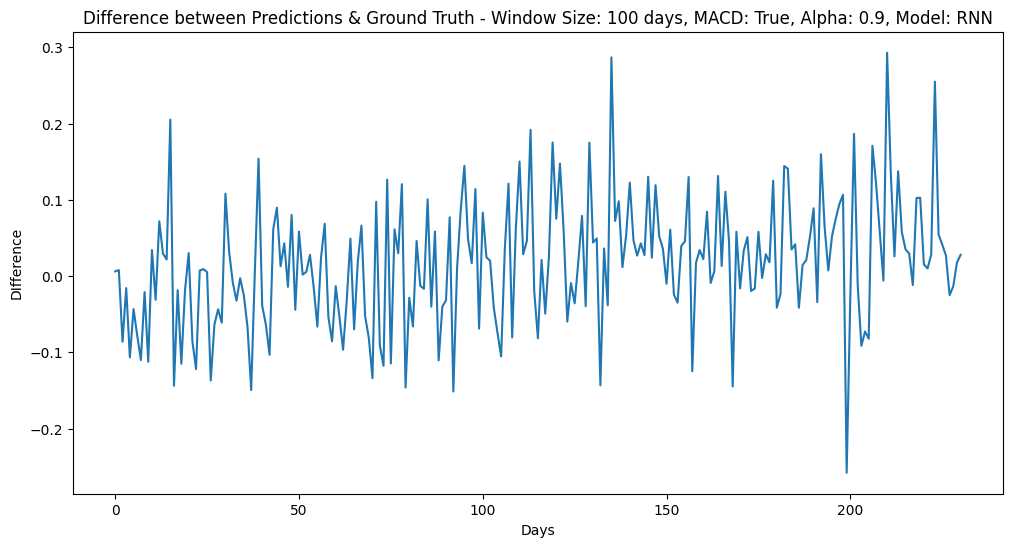

Experiment - Window Size: 100 days, MACD: True, Alpha: 0.9, Model: LSTM
Epoch 1/10, Train Loss: 0.0178, Val Loss: 0.0115
Epoch 2/10, Train Loss: 0.0091, Val Loss: 0.0015
Epoch 3/10, Train Loss: 0.0017, Val Loss: 0.0060
Epoch 4/10, Train Loss: 0.0006, Val Loss: 0.0050
Epoch 5/10, Train Loss: 0.0005, Val Loss: 0.0042
Epoch 6/10, Train Loss: 0.0005, Val Loss: 0.0035
Epoch 7/10, Train Loss: 0.0005, Val Loss: 0.0030
Epoch 8/10, Train Loss: 0.0004, Val Loss: 0.0026
Epoch 9/10, Train Loss: 0.0004, Val Loss: 0.0022
Epoch 10/10, Train Loss: 0.0004, Val Loss: 0.0020


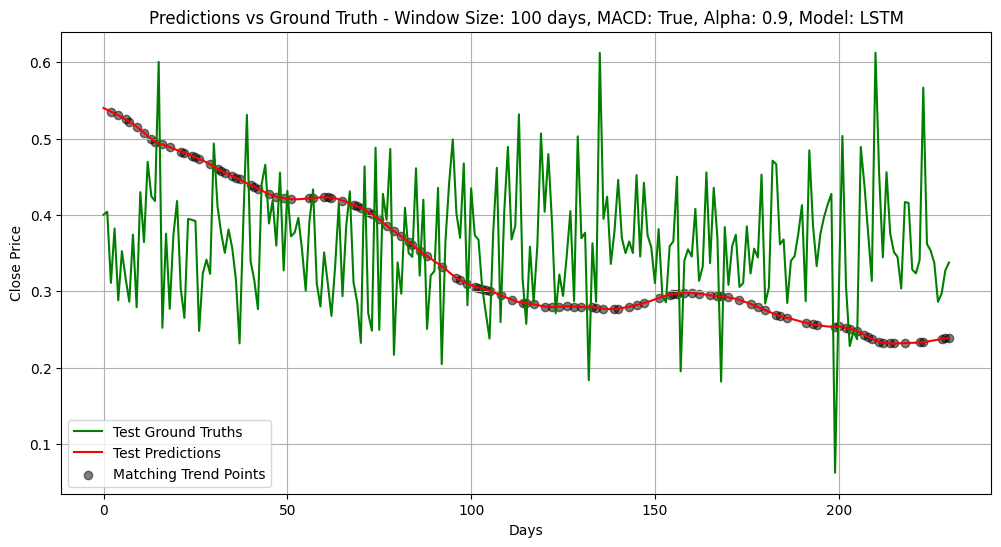

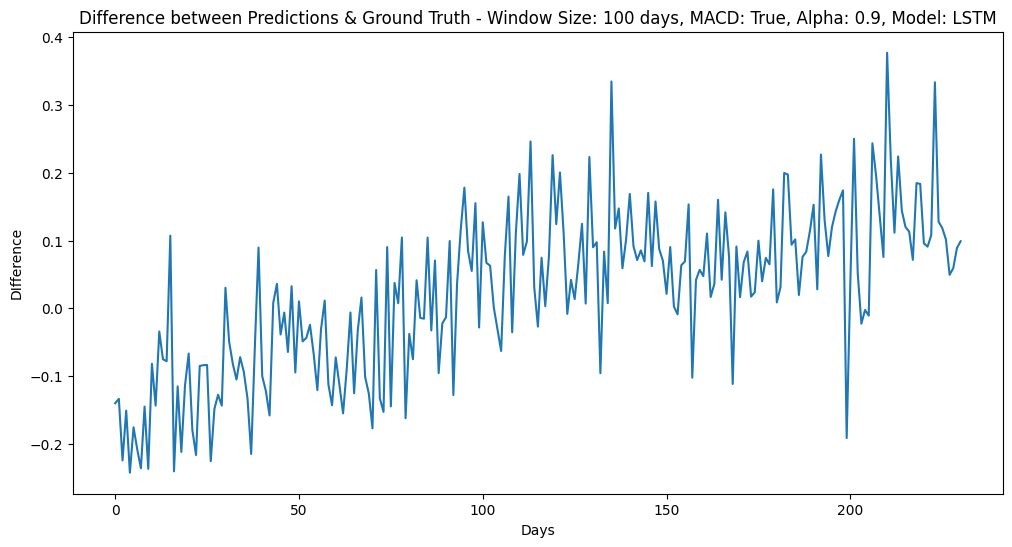

Metrics saved.


In [ ]:
# set stock and read data (data is avaialble only for Google based on project requirements)
stock = 'GOOG'
stock_path = os.path.join(INPUT_DIR, f"{stock}.csv")
stock_data = pd.read_csv(stock_path)
stock_data['pct_change'] = stock_data['Close'].pct_change()*100 # calculate target column
stock_data = stock_data.dropna(subset=['pct_change']) # drops first row since first row would be nan after pct_change

# define experiment configurations
window_sizes = [5, 50, 100]
macd_options = [False, True]
alphas = [0.0, 0.9]
model_options = ['RNN', 'LSTM']

metrics = [] # used to store metrics

# for each combination
for seq_length in window_sizes:
    for use_macd in macd_options:
        for alpha in alphas:
            for model_type in model_options:
                print(f"Experiment - Window Size: {seq_length} days, MACD: {use_macd}, Alpha: {alpha}, Model: {model_type}")

                # set feature set
                if use_macd:
                    # Add MACD
                    stock_data = compute_macd(stock_data, 'Close', 50, 200, 50)
                    features_to_use = ['Volume', 'Low', 'Open', 'High', 'Close', 'macd', 'macd_signal', 'pct_change']
                else:
                    features_to_use = ['Volume', 'Low', 'Open', 'High', 'Close', 'pct_change']

                # min-max scale the data
                scaled_data, min_vals, max_vals = minmax_scale(stock_data[features_to_use].values)
                stock_data[features_to_use] = scaled_data  # Update the dataframe with scaled values
                data = stock_data[features_to_use].values

                # split the data
                train_size = int(0.8 * len(data))
                val_size = int(0.15 * len(data))
                test_size = len(data) - train_size - val_size

                train_data, val_data, test_data = (
                    data[:train_size],
                    data[train_size:train_size + val_size],
                    data[train_size + val_size:]
                ) # split

                # create datasets and dataloaders
                train_dataset = StockDataset(train_data, seq_length)
                val_dataset = StockDataset(val_data, seq_length)

                train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
                val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

                # define model and training parameters
                input_size = len(features_to_use) - 1  # minus 1 since excluding target
                hidden_size = 64
                output_size = 1

                if model_type == 'RNN':
                    model = CustomRNN(input_size, hidden_size, output_size).to(device)
                else:
                    model = CustomLSTM(input_size, hidden_size, output_size).to(device)
                
                lr = 0.00005
                epochs = 10
                criterion = nn.MSELoss()
                optimizer = Adam(model.parameters(), lr=lr)

                # train and validate the model
                train_losses = []
                val_losses = []
                for epoch in range(epochs):
                    train_loss = train_model(model, train_loader, criterion, optimizer, device, alpha=alpha)
                    val_loss = validate_model(model, val_loader, criterion, device, alpha=alpha)
                    train_losses.append(train_loss)
                    val_losses.append(val_loss)

                    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

                test_data = np.concatenate((val_data[-seq_length:], test_data)) # get the test data (including the last seq_length days of validation data to get output for initial values of test data)
                test_predictions, test_actuals = test_model(model, test_data, seq_length, device) # get predictions and actuals
                test_rmse = mean_squared_error(test_actuals, test_predictions, squared=False) # calculate RMSE
                test_mae = mean_absolute_error(test_actuals, test_predictions) # calculate MAE

                # append metrics for this experiment
                metrics.append({
                    "Window Size": seq_length,
                    "MACD": use_macd,
                    "Alpha": alpha,
                    "Model": model_type,
                    "Test RMSE": test_rmse,
                    "Test MAE": test_mae,
                })

                actual_trend = np.diff(test_actuals) > 0  # true for increase, false for decrease
                prediction_trend = np.diff(test_predictions) > 0  # true for increase, false for decrease
                
                # get indices where actual and predicted trends match
                matching_indices = np.where(actual_trend == prediction_trend)[0] + 1  # shifting by 1 since we are comparing differences
                
                # plot predictions and ground truth values
                plt.figure(figsize=(12, 6))
                plt.plot(range(len(test_actuals)), test_actuals, label="Test Ground Truths", color="green")
                plt.plot(range(len(test_predictions)), test_predictions, label="Test Predictions", color="red")
                scatter_point_data = [test_predictions[i] for i in matching_indices] # get matching trend points
                plt.scatter(matching_indices, scatter_point_data, color="black", label="Matching Trend Points", alpha=0.5, linewidths=1) # plot trend points
                plt.legend()
                plt.title(f"Predictions vs Ground Truth - Window Size: {seq_length} days, MACD: {use_macd}, Alpha: {alpha}, Model: {model_type}")
                plt.xlabel("Days")
                plt.ylabel("Close Price")
                plt.grid()
                plt.savefig(os.path.join(FIGURES_DIR, f"window_size_{seq_length}_macd_{use_macd}_alpha_{alpha}_model_{model_type}.png"))
                plt.show()

                # plot differences between predictions and ground truth
                plt.figure(figsize=(12,6))
                plt.plot(
                    range(len(test_actuals)),
                    test_actuals - test_predictions,
                    label="Difference",
                )
                plt.xlabel("Days")
                plt.ylabel("DIfference")
                plt.title(f"Difference between Predictions & Ground Truth - Window Size: {seq_length} days, MACD: {use_macd}, Alpha: {alpha}, Model: {model_type}")
                plt.savefig(os.path.join(FIGURES_DIR, f"differences_window_size_{seq_length}_macd_{use_macd}_alpha_{alpha}_model_{model_type}.png"))
                plt.show()

# save metrics in a dataframe
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(os.path.join(RESULTS_DIR, "experiment_metrics_all_combinations.csv"), index=False)
print("Metrics saved.")